# ImageNet Angle Classification

This experiment will attempt to classify image angle by extracting features from different layers of an Xception model. The Xception model will generate features for 128x128 px images, and a classifier will use those feature maps to predict angle. To fix memory issues, mixed precision training will be used, with Xception using float16 and the classifier using float32.

## Setup

In [1]:
!nvidia-smi

Mon Sep 16 19:07:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:8A:00.0 Off |                    0 |
| N/A   32C    P0             42W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# !pip install --upgrade pip

In [3]:
# !pip install tensorflow[and-cuda]

In [4]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-09-16 19:07:47.425997: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 19:07:47.441900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 19:07:47.457171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 19:07:47.461828: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 19:07:47.473034: I tensorflow/core/platform/cpu_feature_guar

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [6]:
import numpy as np
import keras
from keras import layers, regularizers, mixed_precision
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.utils.class_weight import compute_class_weight
from time import time
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy, Policy

In [7]:
!pwd
!ls koa_scratch

/home/jctactay
images


In [8]:
policy = Policy('mixed_float16')
set_global_policy(policy)

## Data preprocessing

In [9]:
# load/reconcile labels
cols = ["species","image","angle"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]

cols = ["species","filename","angle"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","angle"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)
target_labels = ['1', '2', '8']

In [10]:
print(len(labels))

3592


In [11]:
is_na = labels.angle.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')
len(labels)

2696

In [23]:
angle_2, angle_3, angle_4, angle_8 = "", "", "", ""
        
for index, row in labels.iterrows():
    if (row.angle == 2):
        print(row)
        angle_2 = row.image
        break
for index, row in labels.iterrows():
    if (row.angle == 3):
        print(row)
        angle_3 = row.image
        break

for index, row in labels.iterrows():
    if (row.angle == 4):
        print(row)
        angle_4 = row.image
        break
for index, row in labels.iterrows():
    if (row.angle == 8):
        print(row)
        angle_8 = row.image
        break

species    short_finned_pilot_whale
image            046a62ecd22db2.jpg
angle                           2.0
Name: 24, dtype: object
species    short_finned_pilot_whale
image            076b625ea5e34c.jpg
angle                           3.0
Name: 53, dtype: object
species                  false_killer_whale
image      PIFSC_20130706-S14a_Y-2753ed.jpg
angle                                   4.0
Name: 2199, dtype: object
species                  bottlenose_dolphin
image      PIFSC_20130715-S29a_Y-6247ed.jpg
angle                                   8.0
Name: 1934, dtype: object


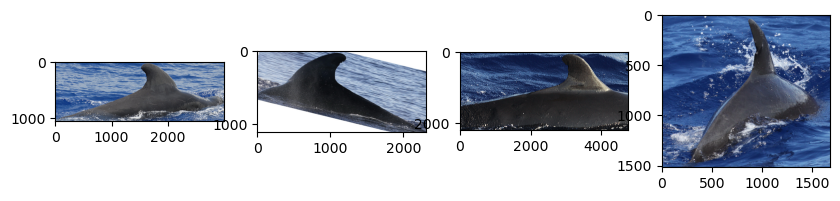

In [25]:
fig, ax = plt.subplots(1,4, figsize=(10,10))
ax[0].imshow(Image.open("/home/jctactay/koa_scratch/images/"+angle_2))
ax[1].imshow(Image.open("/home/jctactay/koa_scratch/images/"+angle_3))
ax[2].imshow(Image.open("/home/jctactay/koa_scratch/images/"+angle_4))
ax[3].imshow(Image.open("/home/jctactay/koa_scratch/images/"+angle_8))

Angles of 3 and 4 seem closer to 2 than 8

In [26]:
for index, row in labels.iterrows():
    if row.angle == 1.0:
       labels.at[index, 'angle'] = 0
    elif row.angle == 2.0 or row.angle == 3.0 or row.angle == 4.0:
        labels.at[index, 'angle'] = 1
    else:
        labels.at[index, 'angle'] = 2

In [27]:
value_counts = labels.angle.value_counts()
value_counts.index = pd.to_numeric(value_counts.index)
value_counts = value_counts.sort_index()
value_counts

angle
0.0    2512
1.0     167
2.0      17
Name: count, dtype: int64

In [28]:
paths = []
for index, row in labels.iterrows():
    paths.append("/home/jctactay/koa_scratch/images/" + row.image)
assert len(labels) == len(paths)

In [29]:
# image reading/processing
def load_img(path):
    img = Image.open(path)
    img = img.resize((128,128))
    np_img = np.array(img)/127.5 - 1
    return os.path.basename(path), np_img
def load_images_into_dict():
    imgs = {}

    num_workers = 8
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_img = {executor.submit(load_img, path): path for path in paths}

        for future in as_completed(future_to_img):
            img_name, img = future.result()
            imgs[img_name] = img

    return imgs
    
t0 = time()

imgs = load_images_into_dict()
print(f"Done in {time() - t0: .3f}s")

Done in  130.554s


In [30]:
assert len(imgs) == len(labels)

In [31]:
# check for nans
for k, v in zip(imgs.keys(), imgs.values()):
    if np.isnan(v.any()):
        print(k)

In [32]:
print(labels)

                       species                           image  angle
6     short_finned_pilot_whale              01614d81068ff6.jpg    0.0
10    short_finned_pilot_whale              0246806606bc80.jpg    0.0
15    short_finned_pilot_whale              029eef21f79e91.jpg    0.0
16    short_finned_pilot_whale              02e6e47b13575a.jpg    0.0
17    short_finned_pilot_whale              030acd6311f20a.jpg    0.0
...                        ...                             ...    ...
3587        melon_headed_whale  PIFSC_20110503-S3_C-5088a-.jpg    0.0
3588        melon_headed_whale  PIFSC_20110503-S3_Z-3913a-.jpg    1.0
3589        melon_headed_whale  PIFSC_20110503-S3_Z-3914ed.jpg    0.0
3590        melon_headed_whale  PIFSC_20110503-S3_C-4846a-.jpg    0.0
3591        melon_headed_whale  PIFSC_20110503-S3_Z-3866ed.jpg    0.0

[2696 rows x 3 columns]


In [33]:
Y = labels.angle
print(np.unique(Y))
X = np.array([imgs[i] for i in labels.image])
print(len(Y))
print(len(X))

[0. 1. 2.]
2696
2696


## Xception model

In [34]:
# load pretrained model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(128,128,3),
    include_top=False)
# freeze base model
base_model.trainable = False
base_model.summary(show_trainable=True)

2024-09-16 19:18:06.174855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ cast (Cast)       │ (None, 128,     │         0 │ input_layer[0… │   -   │
│                   │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1      │ (None, 63, 63,  │       864 │ cast[0][0]     │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_bn   │ (None, 63, 63,  │       128 │ block1_conv1[… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_act  │ (None, 63, 63,  │         0 │ block1_conv1_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2      │ (None, 61, 61,  │    18,432 │ block1_conv1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_bn   │ (None, 61, 61,  │       256 │ block1_conv2[… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_act  │ (None, 61, 61,  │         0 │ block1_conv2_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1   │ (None, 61, 61,  │     8,768 │ block1_conv2_… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │         0 │ block2_sepcon… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2   │ (None, 61, 61,  │    17,536 │ block2_sepcon… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 31, 31,  │     8,192 │ block1_conv2_… │   N   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_pool       │ (None, 31, 31,  │         0 │ block2_sepcon… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 31, 31,  │       512 │ conv2d[0][0]   │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 31, 31,  │         0 │ block2_pool[0… │   - 

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

## Helper functions

In [35]:
def plot_history(histories):
    num_subplots = len(histories[0].history.keys())//2 * len(histories)
    fig = plt.figure(figsize=(10,10))
    subfigs = fig.subfigures(num_subplots//2)
    for i, history in enumerate(histories):
        ax = subfigs[i].subplots(1, 2)
        f = 0
        subfigs[i].suptitle(f"Fold {i+1}")
        for metric in history.history.keys():
            ax[f].plot(history.history[metric], label=metric)
            ax[f].legend()
            f = int(not f)

In [36]:
def extract_features(layer_name):
    extractor = keras.Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
    features = extractor.predict(X)
    return features

In [37]:
def build_model(model_arg=None, features=None, num_classes=3):
    if model_arg is None:
        model = keras.Sequential([
            tf.keras.Input(shape=features.shape[1:]),
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dense(1024, activation='relu'),
            keras.layers.Dropout(0.3),
            # keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4), dtype='float32'),
            # keras.layers.Dropout(0.3),
            keras.layers.Dense(num_classes, activation='softmax', dtype='float32')
        ])
    optimizer = keras.optimizers.Adam(1e-5)
    # optimizer = mixed_precision.LossScaleOptimizer(optimizer)

    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [38]:
def extract_train_predict_cv(layer_name, callback_arg=None, model_arg=None, n_splits=5):
    features = extract_features(layer_name)
    print("Shape of features:", features.shape)
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    classes = np.unique(Y)
    num_classes = len(classes)
    fold_no = 1
    all_preds = np.zeros((X.shape[0], num_classes))
    histories = []
    for train_index, val_index in cv.split(X=features,y=Y):
        model = build_model(model_arg, features, num_classes)
        if callback_arg is None:
            callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=5)
        print(f'Training on fold {fold_no}...')
        X_train, X_val = features[train_index], features[val_index]
        Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
        print("Class weights:", class_weights)
        class_weights_dict = dict(zip(np.unique(Y_train), class_weights))
        sample_weights = np.array([class_weights_dict[label] for label in Y_train])
        history = model.fit(X_train, Y_train, batch_size=32, epochs=30, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)
        histories.append(history)
        pred_soft = model.predict(X_val)
        all_preds[val_index] = pred_soft
        fold_no += 1
    preds = np.argmax(all_preds, axis=1)
    report = classification_report(Y, preds, target_names=target_labels)
    cm = confusion_matrix(Y, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
    return histories, report, disp

In [39]:
def plot_feature_maps(feature_maps):
    num_features = feature_maps.shape[-1]
    size = feature_maps.shape[1]
    num_cols = 8
    num_rows = num_features // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30))
    for i in range(num_features):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(feature_maps[0, :, :, i])
        ax.axis('off')
    plt.show()

## block5_sepconv1_act (baseline)

Treat this layer as the baseline based on overall feature extraction experiment

In [40]:
histories, report, disp = extract_train_predict_cv('block5_sepconv1_act', n_splits=3)

2024-09-16 19:26:56.996386: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1726514817.002705  708758 service.cc:146] XLA service 0x149e18216690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726514817.002728  708758 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-09-16 19:26:57.013673: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-16 19:26:57.110698: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


51/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

I0000 00:00:1726514818.563515  708758 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.4486 - loss: 1.4496 - val_accuracy: 0.0567 - val_loss: 2.0318
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3481 - loss: 1.4425 - val_accuracy: 0.3515 - val_loss: 1.1147
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5663 - loss: 0.9127 - val_accuracy: 0.5273 - val_loss: 0.9982
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6136 - loss: 0.8157 - val_accuracy: 0.6307 - val_loss: 0.9595
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6409 - loss: 0.7506 - val_accuracy: 0.6541 - val_loss: 0.8489
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6646 - loss: 0.6735 - val_accuracy: 0.7942 - val_loss: 0.7316
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7202 - loss: 0.6460 - val_a

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

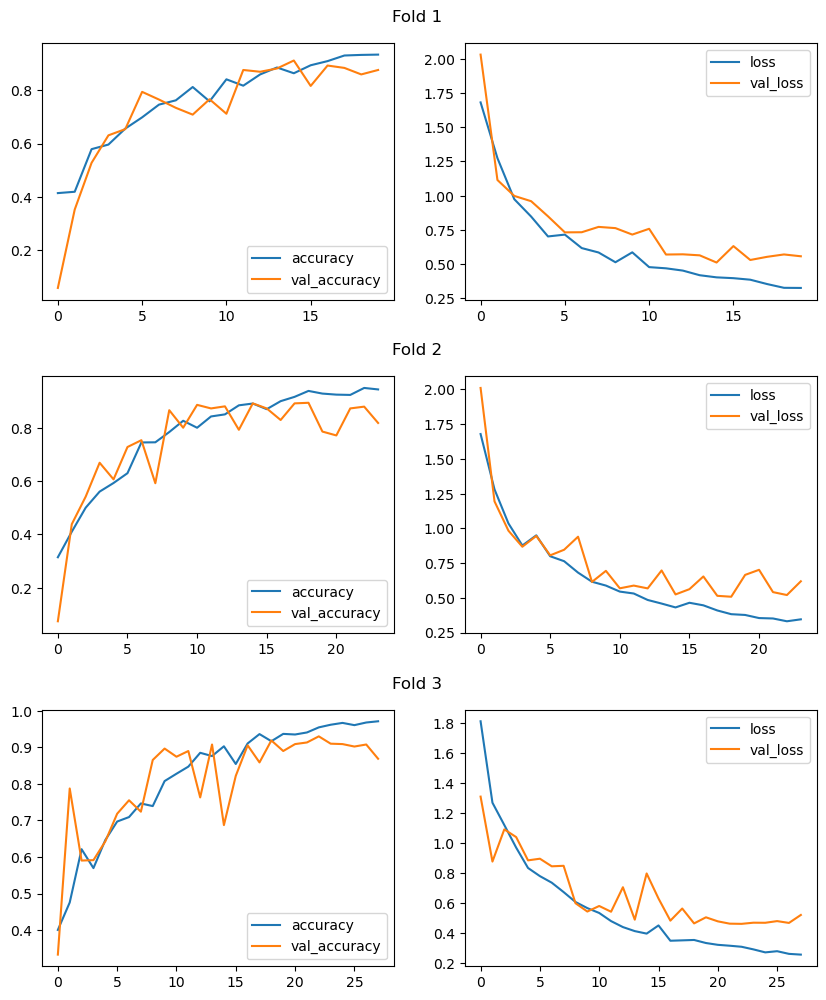

In [41]:
plot_history(histories)

In [42]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.97      0.95      2512
           2       0.16      0.08      0.10       167
           8       0.00      0.00      0.00        17

    accuracy                           0.91      2696
   macro avg       0.36      0.35      0.35      2696
weighted avg       0.88      0.91      0.90      2696



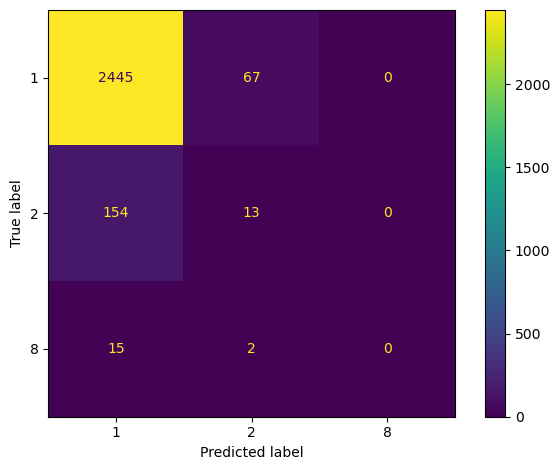

In [43]:
disp.plot()
plt.tight_layout()

Predicting mainly ones; test other layers

## block4_sepconv1_act

In [69]:
histories, report, disp = extract_train_predict_cv('block4_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Shape of features: (2696, 16, 16, 256)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4098 - loss: 2.3690 - val_accuracy: 0.0311 - val_loss: 2.1997
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1773 - loss: 1.5003 - val_accuracy: 0.7820 - val_loss: 0.9812
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4735 - loss: 1.4038 - val_accuracy: 0.7219 - val_loss: 1.0424
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5256 - loss: 1.0987 - val_accuracy: 0.9055 - val_loss: 0.9022
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5380 - loss: 1.0765 - val_accuracy: 0.8287 - val_loss: 0.9132
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5293 - loss: 1.0041 - val_accuracy: 0.8476 - val_loss: 0.8109
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5565 - loss: 1.1885 - val_

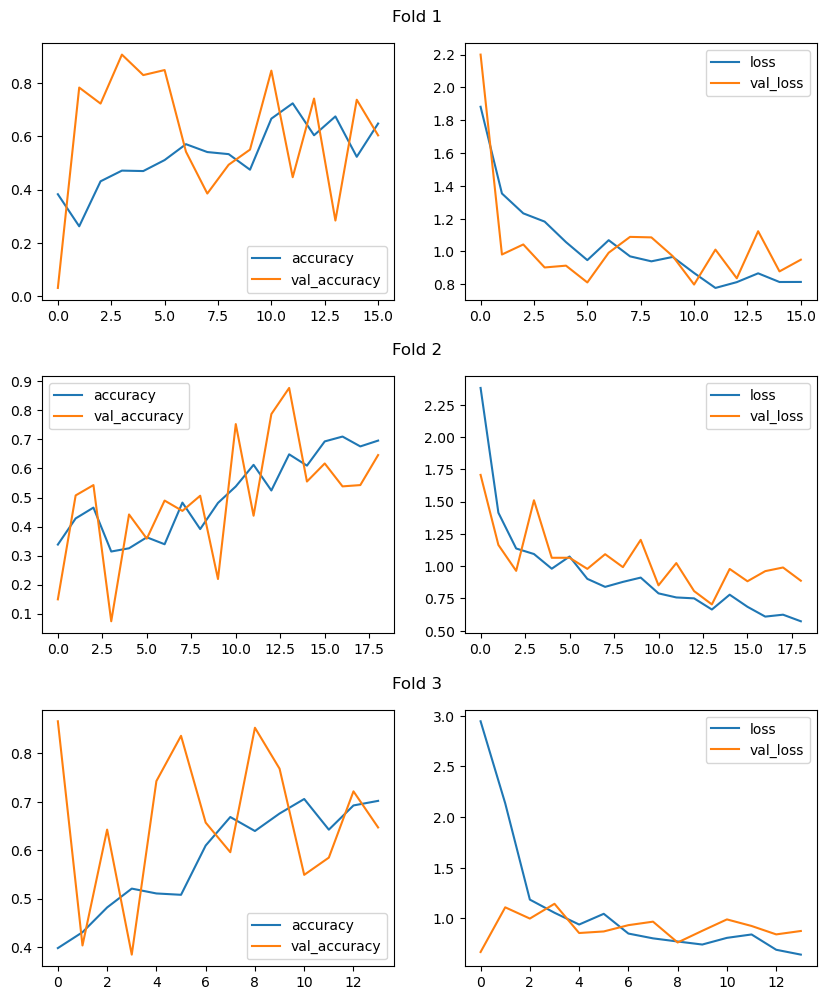

In [70]:
plot_history(histories)

In [71]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.91      0.92      2512
           2       0.09      0.13      0.10       167
           8       0.00      0.00      0.00        17

    accuracy                           0.86      2696
   macro avg       0.34      0.35      0.34      2696
weighted avg       0.88      0.86      0.87      2696



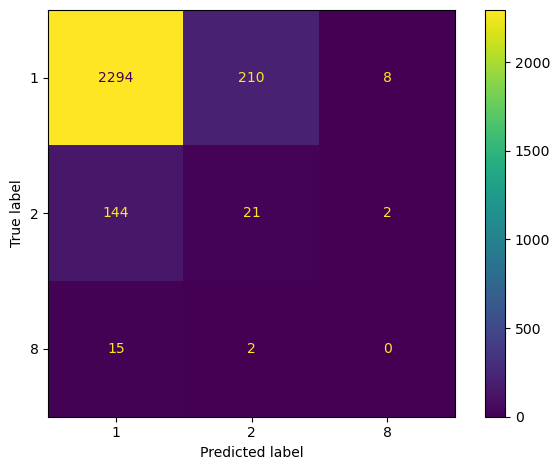

In [72]:
disp.plot()
plt.tight_layout()

## block7_sepconv1_act

In [141]:
histories, report, disp = extract_train_predict_cv('block7_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4548 - loss: 1.9990 - val_accuracy: 0.3326 - val_loss: 1.3823
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4322 - loss: 1.2231 - val_accuracy: 0.4483 - val_loss: 1.1742
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5872 - loss: 0.8441 - val_accuracy: 0.6240 - val_loss: 0.9857
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6288 - loss: 0.7476 - val_accuracy: 0.7297 - val_loss: 0.8442
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6753 - loss: 0.7440 - val_accuracy: 0.7953 - val_loss: 0.7524
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6823 - loss: 0.7325 - val_accuracy: 0.7108 - val_loss: 0.8043
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7362 - loss: 0.6285 - val_a

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

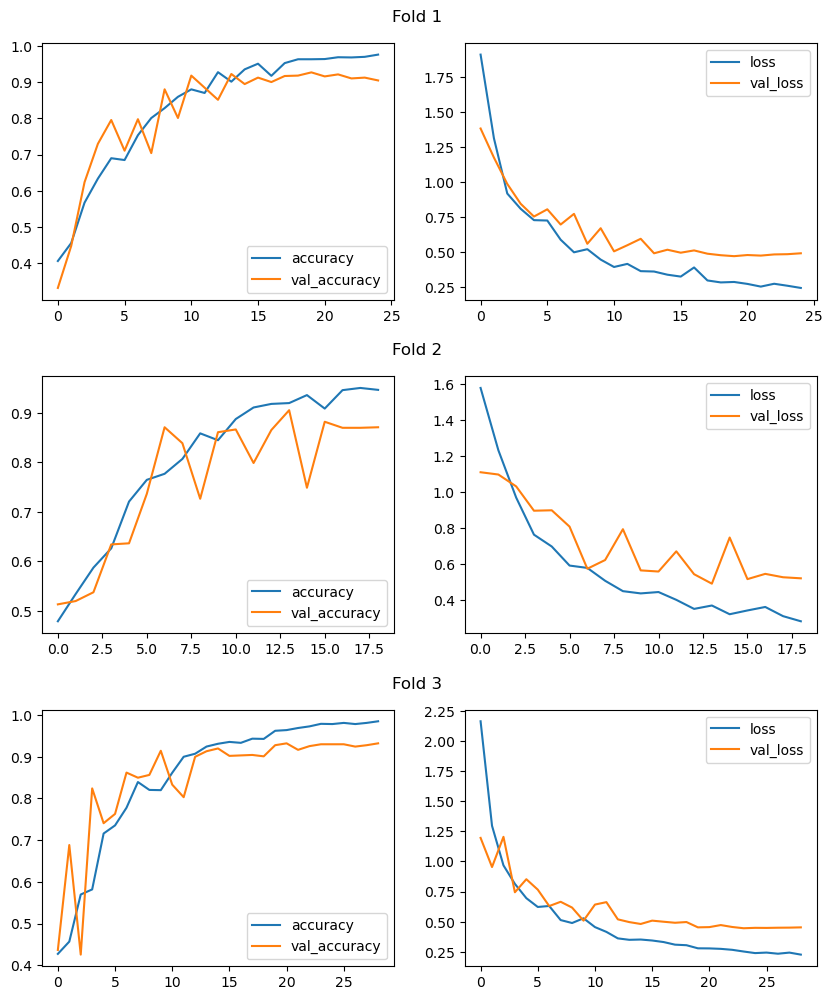

In [142]:
plot_history(histories)

In [143]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.99      0.96      2512
           2       0.16      0.04      0.07       167
           8       0.00      0.00      0.00        17

    accuracy                           0.92      2696
   macro avg       0.36      0.34      0.34      2696
weighted avg       0.88      0.92      0.90      2696



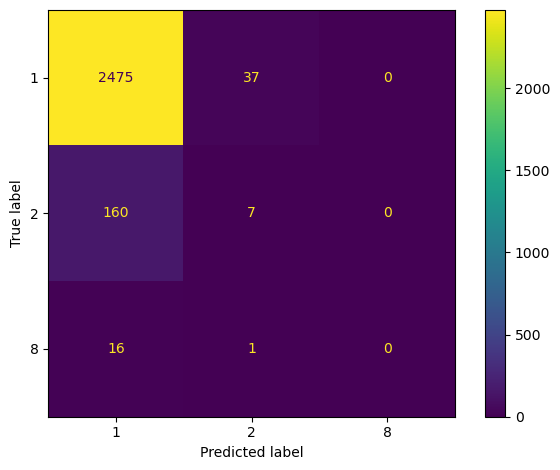

In [144]:
disp.plot()
plt.tight_layout()

## block7_sepconv2_act

In [145]:
histories, report, disp = extract_train_predict_cv('block7_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5627 - loss: 1.5011 - val_accuracy: 0.4972 - val_loss: 1.0828
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5507 - loss: 0.9917 - val_accuracy: 0.5061 - val_loss: 1.1031
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5766 - loss: 0.9588 - val_accuracy: 0.6062 - val_loss: 0.9415
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5834 - loss: 0.8065 - val_accuracy: 0.8176 - val_loss: 0.7463
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6823 - loss: 0.6992 - val_accuracy: 0.7008 - val_loss: 0.8219
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7502 - loss: 0.6232 - val_accuracy: 0.6585 - val_loss: 0.8388
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7555 - loss: 0.5328 - val_a

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

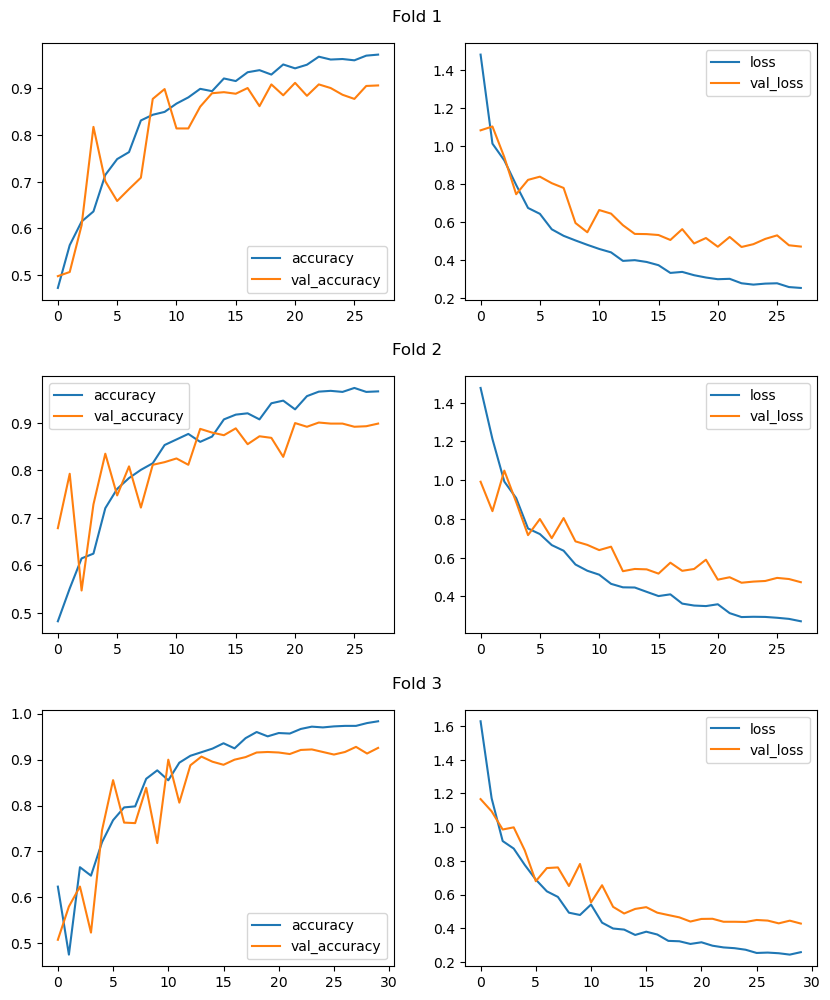

In [146]:
plot_history(histories)

In [147]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.97      0.95      2512
           2       0.18      0.10      0.13       167
           8       0.00      0.00      0.00        17

    accuracy                           0.91      2696
   macro avg       0.37      0.36      0.36      2696
weighted avg       0.88      0.91      0.90      2696



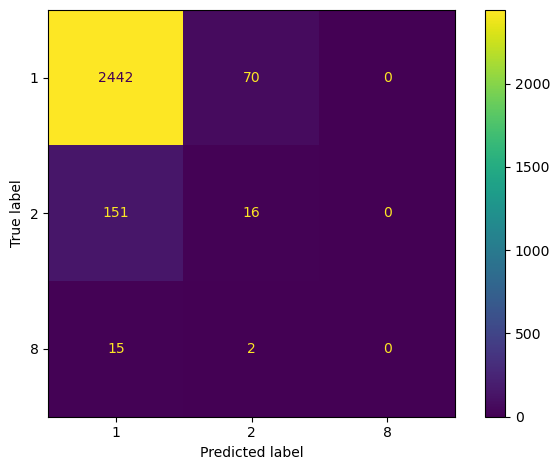

In [148]:
disp.plot()
plt.tight_layout()

## block7_sepconv3_act

In [149]:
histories, report, disp = extract_train_predict_cv('block7_sepconv3_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5493 - loss: 1.6462 - val_accuracy: 0.6051 - val_loss: 0.9832
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7300 - loss: 1.0304 - val_accuracy: 0.4538 - val_loss: 1.0819
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5645 - loss: 0.9466 - val_accuracy: 0.7297 - val_loss: 0.8866
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7382 - loss: 0.8667 - val_accuracy: 0.8498 - val_loss: 0.7544
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8234 - loss: 0.6353 - val_accuracy: 0.8376 - val_loss: 0.7399
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8261 - loss: 0.7018 - val_accuracy: 0.8176 - val_loss: 0.7455
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8105 - loss: 0.6024 - val_a

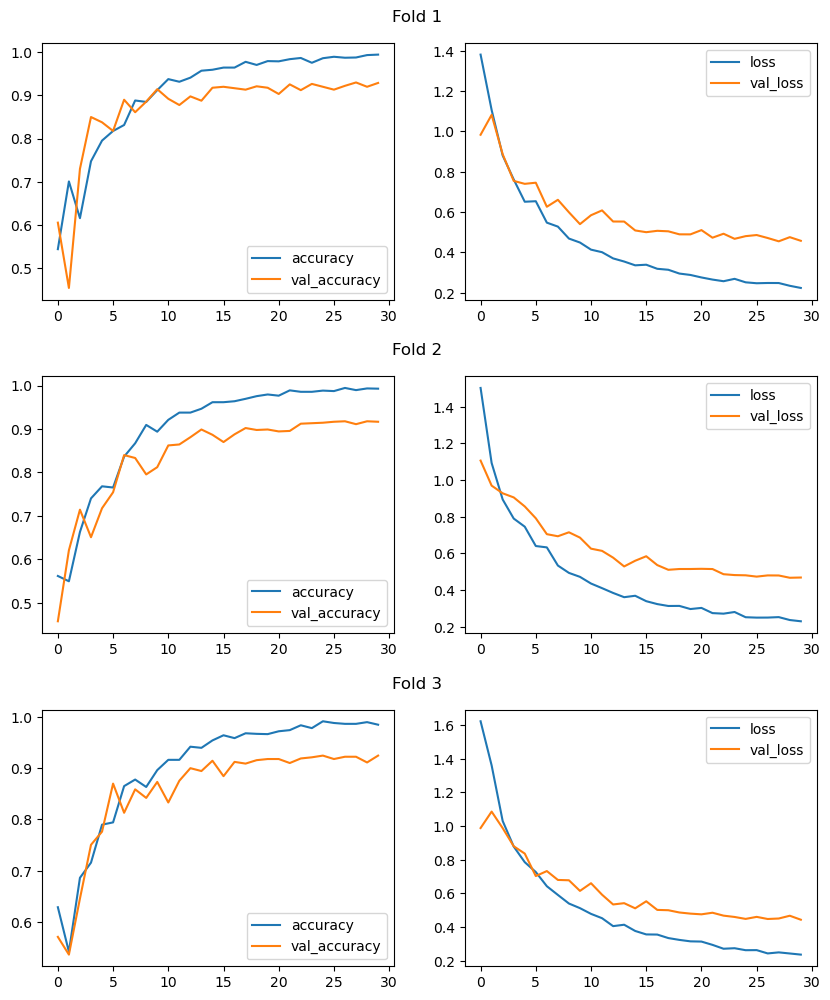

In [150]:
plot_history(histories)

In [151]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.99      0.96      2512
           2       0.23      0.05      0.09       167
           8       0.00      0.00      0.00        17

    accuracy                           0.92      2696
   macro avg       0.39      0.35      0.35      2696
weighted avg       0.88      0.92      0.90      2696



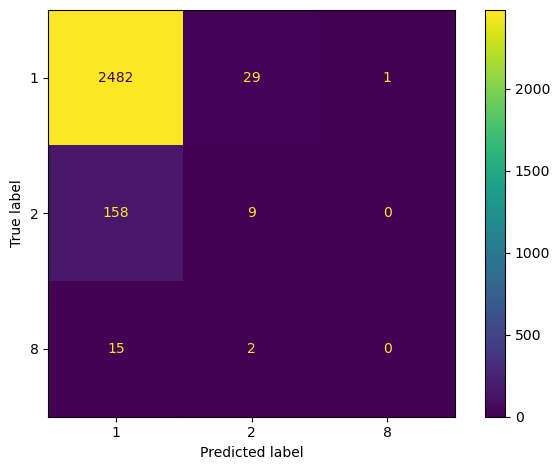

In [152]:
disp.plot()
plt.tight_layout()

## block8_sepconv1_act

In [129]:
histories, report, disp = extract_train_predict_cv('block8_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5157 - loss: 2.3119 - val_accuracy: 0.4249 - val_loss: 1.2795
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4688 - loss: 1.1629 - val_accuracy: 0.5239 - val_loss: 1.0472
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6082 - loss: 0.8889 - val_accuracy: 0.7430 - val_loss: 0.8199
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6296 - loss: 0.7722 - val_accuracy: 0.6340 - val_loss: 0.9030
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6982 - loss: 0.6839 - val_accuracy: 0.7542 - val_loss: 0.7640
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7344 - loss: 0.6751 - val_accuracy: 0.7542 - val_loss: 0.7279
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7721 - loss: 0.5226 - val_a

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

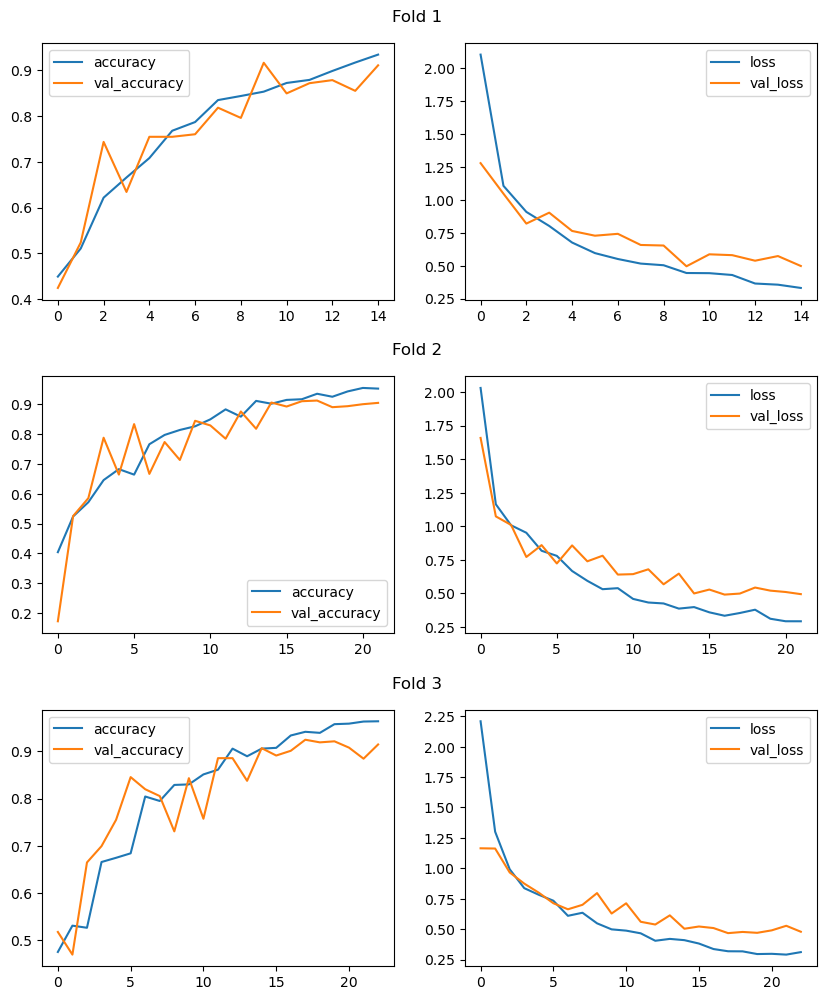

In [130]:
plot_history(histories)

In [131]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.98      0.96      2512
           2       0.18      0.07      0.10       167
           8       0.00      0.00      0.00        17

    accuracy                           0.92      2696
   macro avg       0.37      0.35      0.35      2696
weighted avg       0.88      0.92      0.90      2696



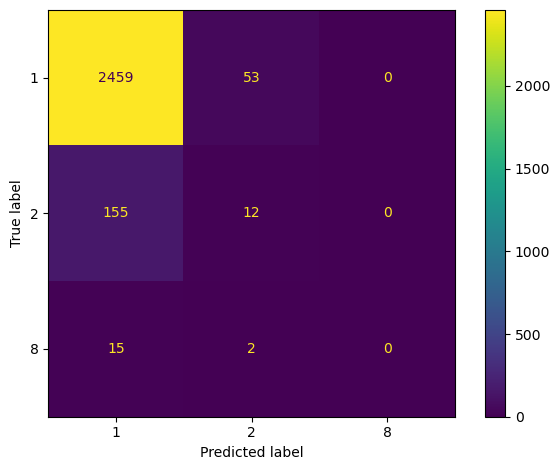

In [132]:
disp.plot()
plt.tight_layout()

## block8_sepconv2_act

In [133]:
histories, report, disp = extract_train_predict_cv('block8_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5522 - loss: 1.7149 - val_accuracy: 0.3771 - val_loss: 1.1377
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4641 - loss: 1.0014 - val_accuracy: 0.7564 - val_loss: 0.9180
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6043 - loss: 0.8736 - val_accuracy: 0.6808 - val_loss: 0.8894
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6731 - loss: 0.7119 - val_accuracy: 0.7697 - val_loss: 0.7899
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8363 - loss: 0.5785 - val_accuracy: 0.6518 - val_loss: 0.8828
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7421 - loss: 0.6098 - val_accuracy: 0.8154 - val_loss: 0.7175
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8100 - loss: 0.5744 - val_a

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

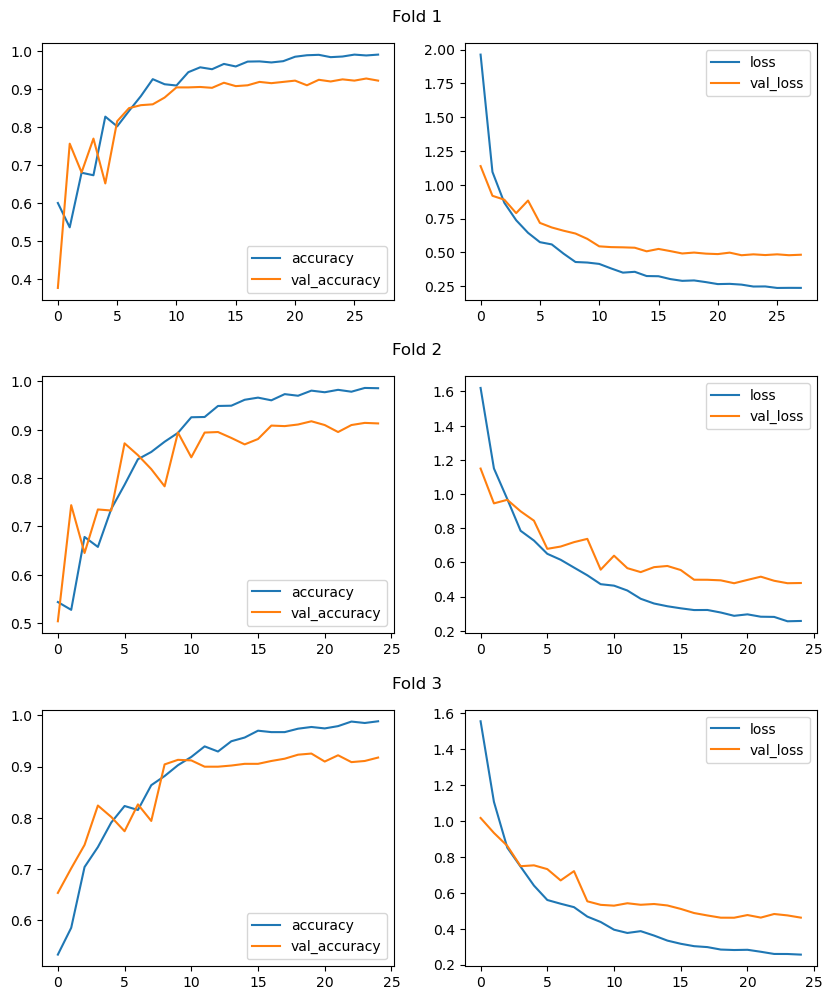

In [134]:
plot_history(histories)

In [135]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.99      0.96      2512
           2       0.20      0.05      0.08       167
           8       0.00      0.00      0.00        17

    accuracy                           0.92      2696
   macro avg       0.38      0.35      0.35      2696
weighted avg       0.88      0.92      0.90      2696



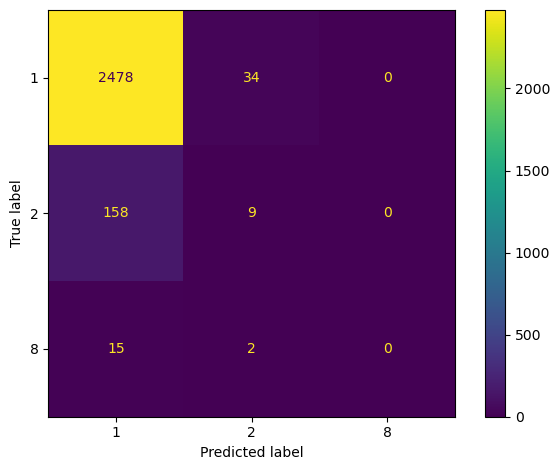

In [136]:
disp.plot()
plt.tight_layout()

## block8_sepconv3_act

In [137]:
histories, report, disp = extract_train_predict_cv('block8_sepconv3_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4617 - loss: 1.7013 - val_accuracy: 0.7575 - val_loss: 0.8305
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7385 - loss: 1.0755 - val_accuracy: 0.6696 - val_loss: 0.9395
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5747 - loss: 0.7810 - val_accuracy: 0.6874 - val_loss: 0.8974
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7378 - loss: 0.6704 - val_accuracy: 0.7653 - val_loss: 0.7958
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8557 - loss: 0.6493 - val_accuracy: 0.8176 - val_loss: 0.7080
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8921 - loss: 0.5114 - val_accuracy: 0.8109 - val_loss: 0.7068
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8737 - loss: 0.4951 - val_a

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

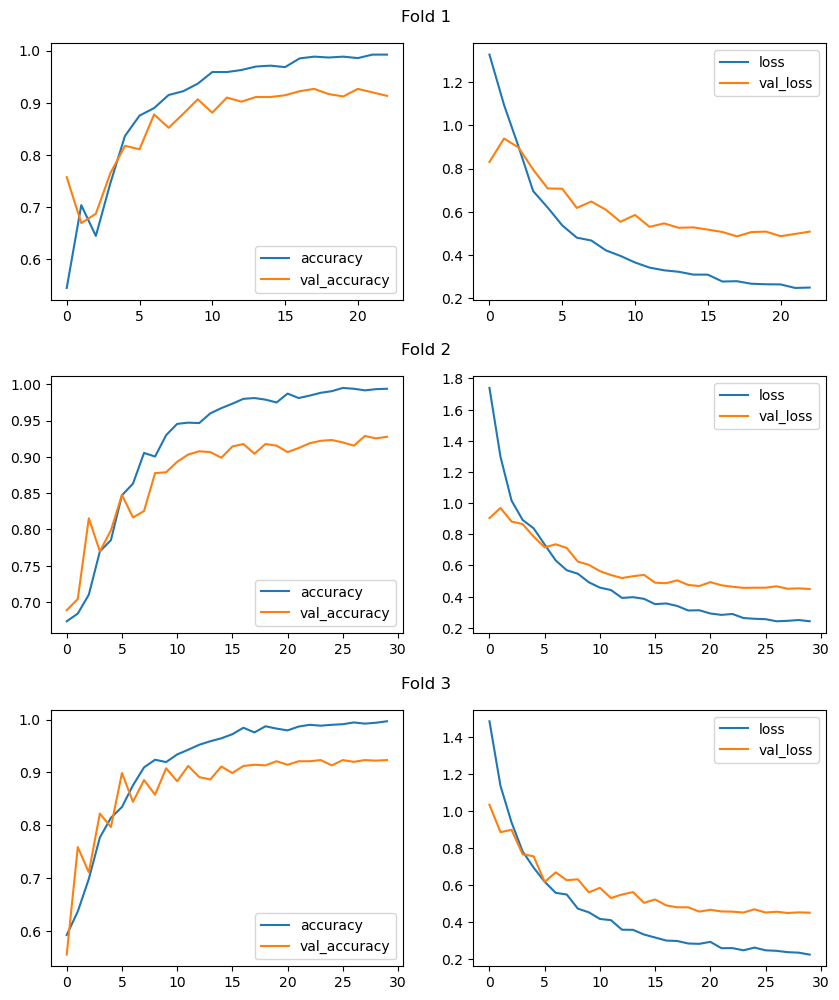

In [138]:
plot_history(histories)

In [139]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.99      0.96      2512
           2       0.24      0.05      0.08       167
           8       0.00      0.00      0.00        17

    accuracy                           0.93      2696
   macro avg       0.39      0.35      0.35      2696
weighted avg       0.89      0.93      0.90      2696



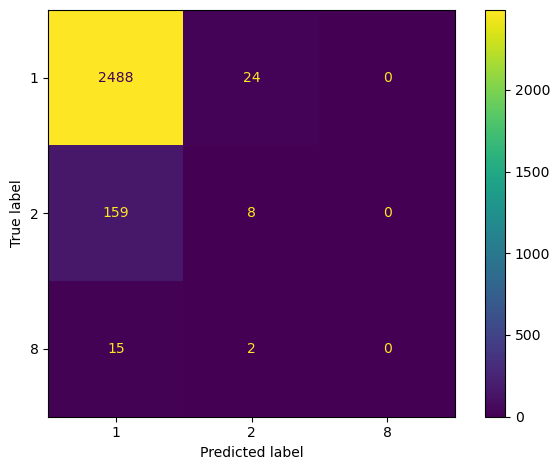

In [140]:
disp.plot()
plt.tight_layout()

## block9_sepconv1_act

In [117]:
histories, report, disp = extract_train_predict_cv('block9_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5289 - loss: 2.9227 - val_accuracy: 0.3993 - val_loss: 1.3679
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3818 - loss: 1.2587 - val_accuracy: 0.5161 - val_loss: 1.0299
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5488 - loss: 0.9338 - val_accuracy: 0.7052 - val_loss: 0.8470
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6806 - loss: 0.7042 - val_accuracy: 0.7419 - val_loss: 0.8113
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7191 - loss: 0.6422 - val_accuracy: 0.8665 - val_loss: 0.5938
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8331 - loss: 0.5147 - val_accuracy: 0.7953 - val_loss: 0.6791
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8425 - loss: 0.4866 - val_a

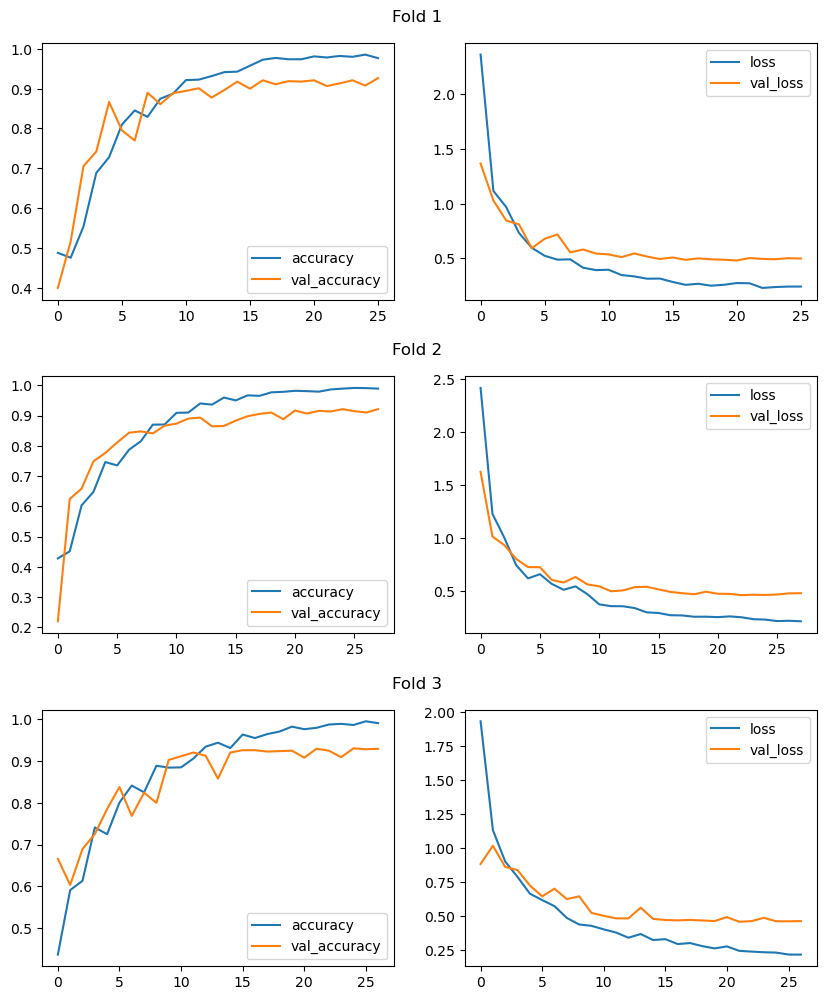

In [118]:
plot_history(histories)

In [119]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.99      0.96      2512
           2       0.21      0.06      0.09       167
           8       0.00      0.00      0.00        17

    accuracy                           0.92      2696
   macro avg       0.38      0.35      0.35      2696
weighted avg       0.88      0.92      0.90      2696



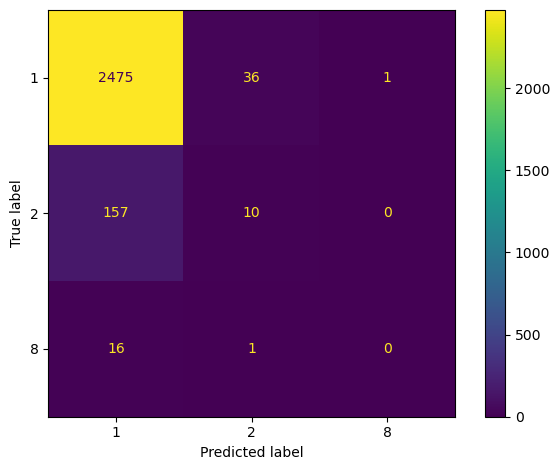

In [120]:
disp.plot()
plt.tight_layout()

## block9_sepconv2_act

In [121]:
histories, report, disp = extract_train_predict_cv('block9_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6515 - loss: 1.6886 - val_accuracy: 0.4372 - val_loss: 1.1931
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4864 - loss: 1.0929 - val_accuracy: 0.6719 - val_loss: 0.9478
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5948 - loss: 0.9323 - val_accuracy: 0.5829 - val_loss: 0.9601
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7353 - loss: 0.7066 - val_accuracy: 0.6652 - val_loss: 0.9042
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6774 - loss: 0.8529 - val_accuracy: 0.7764 - val_loss: 0.7559
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8153 - loss: 0.5588 - val_accuracy: 0.8265 - val_loss: 0.6978
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8733 - loss: 0.5302 - val_a

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

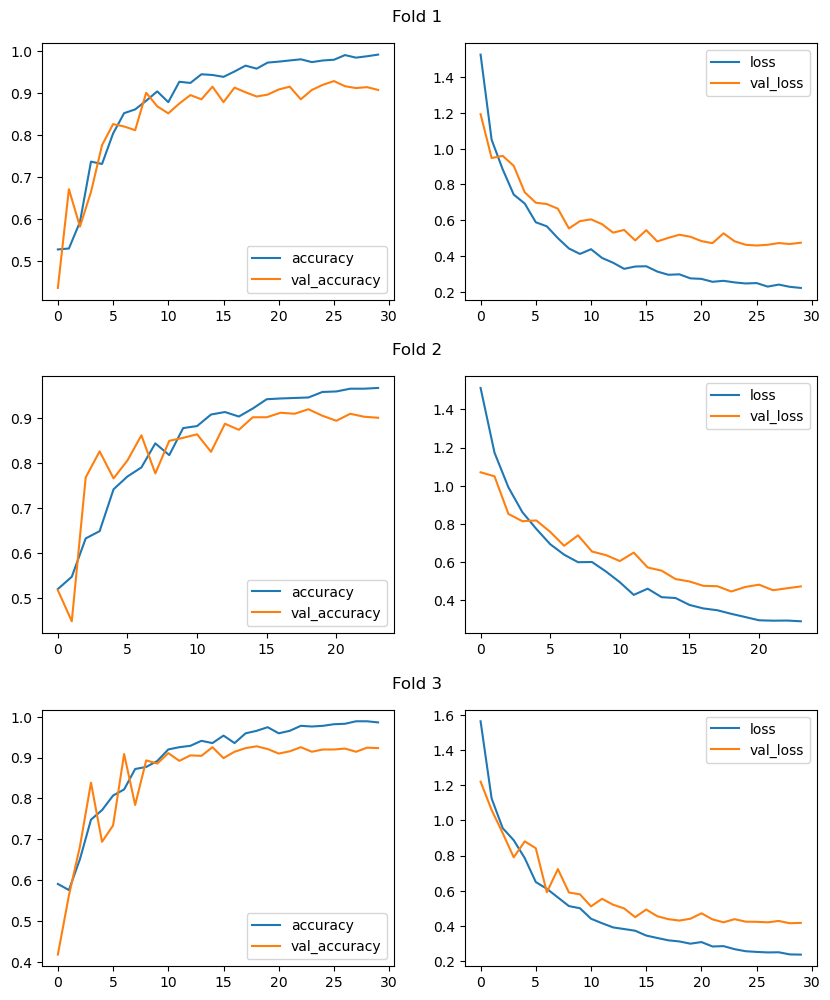

In [122]:
plot_history(histories)

In [123]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.99      0.96      2512
           2       0.29      0.10      0.14       167
           8       0.00      0.00      0.00        17

    accuracy                           0.92      2696
   macro avg       0.41      0.36      0.37      2696
weighted avg       0.89      0.92      0.90      2696



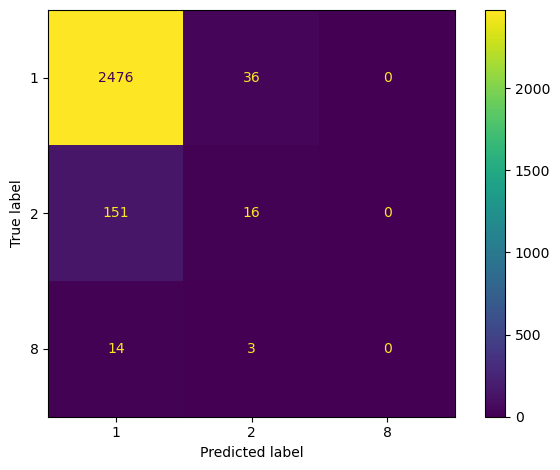

In [124]:
disp.plot()
plt.tight_layout()

## block9_sepconv3_act

In [125]:
histories, report, disp = extract_train_predict_cv('block9_sepconv3_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5905 - loss: 1.5519 - val_accuracy: 0.6185 - val_loss: 1.0812
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5629 - loss: 1.1961 - val_accuracy: 0.6162 - val_loss: 0.9472
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6561 - loss: 0.8801 - val_accuracy: 0.7275 - val_loss: 0.8729
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7193 - loss: 0.7671 - val_accuracy: 0.5973 - val_loss: 0.9220
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6715 - loss: 0.7811 - val_accuracy: 0.7809 - val_loss: 0.7857
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8008 - loss: 0.6131 - val_accuracy: 0.7041 - val_loss: 0.8165
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7157 - loss: 0.6003 - val_a

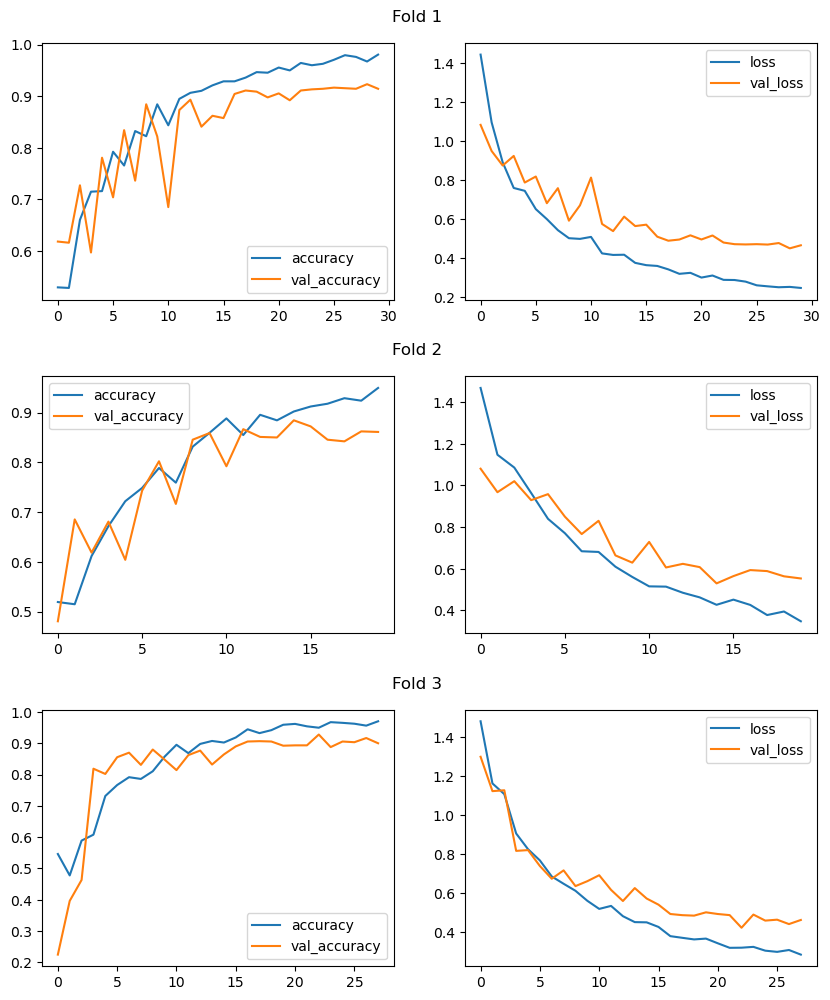

In [126]:
plot_history(histories)

In [127]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.97      0.95      2512
           2       0.17      0.09      0.12       167
           8       0.00      0.00      0.00        17

    accuracy                           0.91      2696
   macro avg       0.37      0.35      0.36      2696
weighted avg       0.88      0.91      0.90      2696



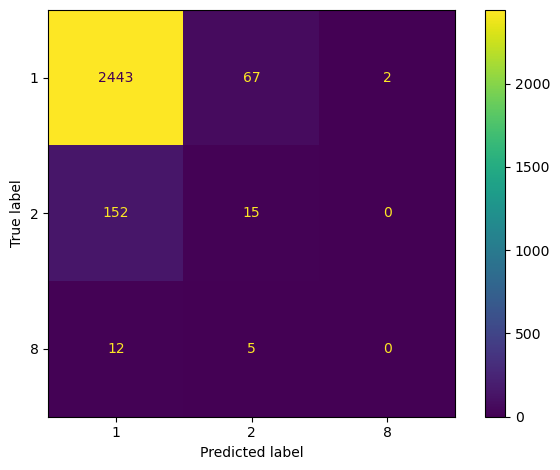

In [128]:
disp.plot()
plt.tight_layout()

## block10_sepconv1_act

In [105]:
histories, report, disp = extract_train_predict_cv('block10_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5209 - loss: 2.6145 - val_accuracy: 0.3904 - val_loss: 1.3003
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4734 - loss: 0.9761 - val_accuracy: 0.6196 - val_loss: 0.9309
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6613 - loss: 0.7910 - val_accuracy: 0.5829 - val_loss: 0.9596
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6173 - loss: 0.7010 - val_accuracy: 0.6707 - val_loss: 0.8208
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7599 - loss: 0.5591 - val_accuracy: 0.7119 - val_loss: 0.7910
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7998 - loss: 0.5675 - val_accuracy: 0.7898 - val_loss: 0.7142
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8686 - loss: 0.4515 - val_a

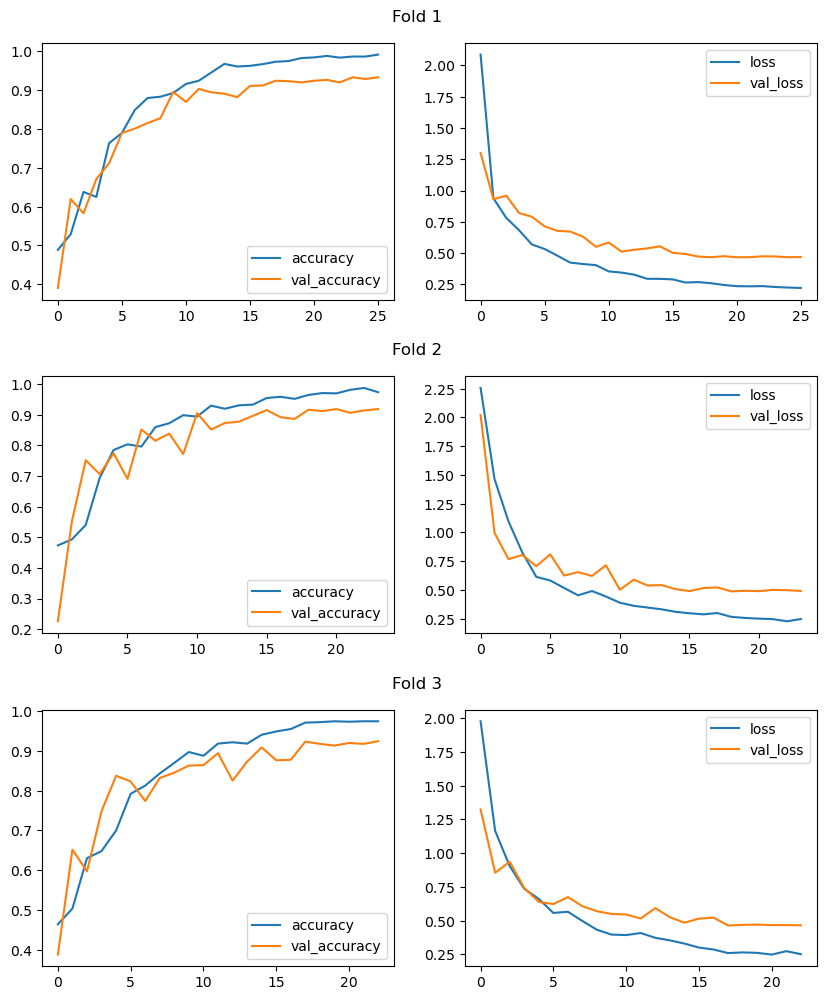

In [106]:
plot_history(histories)

In [107]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.98      0.96      2512
           2       0.20      0.06      0.09       167
           8       0.00      0.00      0.00        17

    accuracy                           0.92      2696
   macro avg       0.38      0.35      0.35      2696
weighted avg       0.88      0.92      0.90      2696



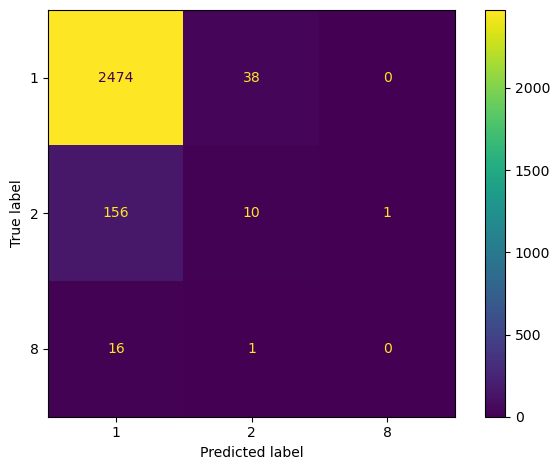

In [108]:
disp.plot()
plt.tight_layout()

## block10_sepconv2_act

In [109]:
histories, report, disp = extract_train_predict_cv('block10_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5383 - loss: 1.8299 - val_accuracy: 0.6396 - val_loss: 1.0127
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6285 - loss: 1.2353 - val_accuracy: 0.6096 - val_loss: 1.0342
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5939 - loss: 1.0352 - val_accuracy: 0.4004 - val_loss: 1.1520
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5878 - loss: 0.7845 - val_accuracy: 0.6429 - val_loss: 0.9427
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6731 - loss: 0.9783 - val_accuracy: 0.7720 - val_loss: 0.7915
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7048 - loss: 0.7855 - val_accuracy: 0.6541 - val_loss: 0.8831
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7333 - loss: 0.8234 - val_a

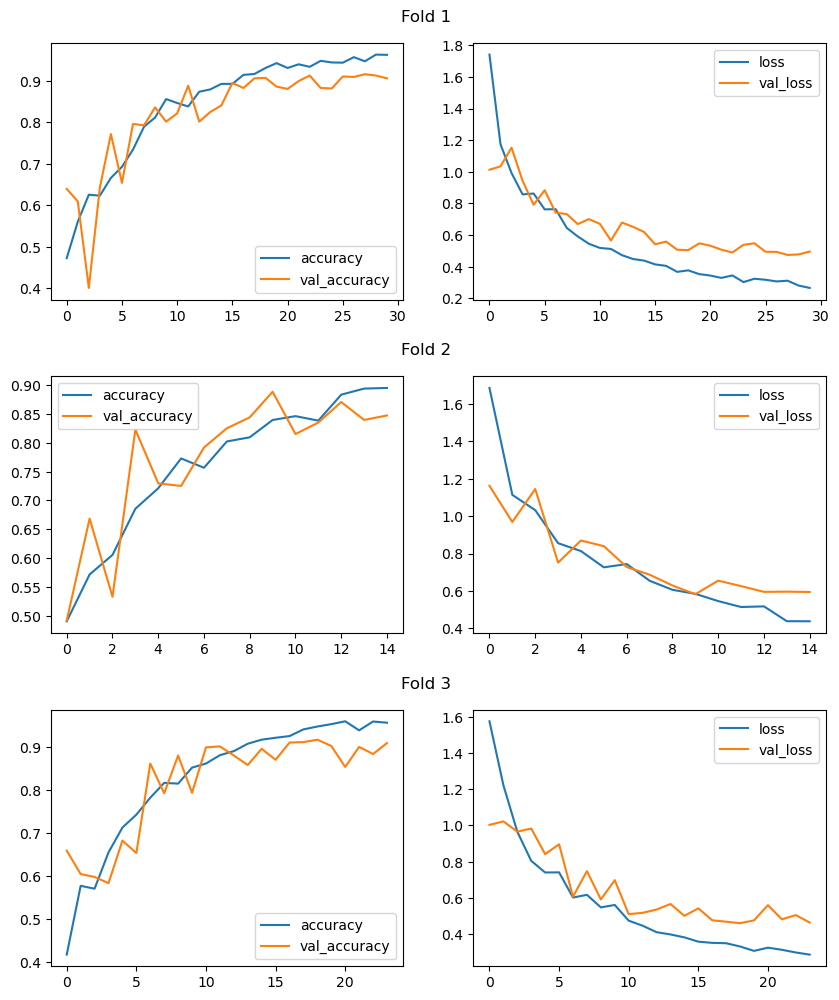

In [110]:
plot_history(histories)

In [111]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.97      0.95      2512
           2       0.20      0.11      0.14       167
           8       0.04      0.06      0.05        17

    accuracy                           0.91      2696
   macro avg       0.40      0.38      0.38      2696
weighted avg       0.89      0.91      0.90      2696



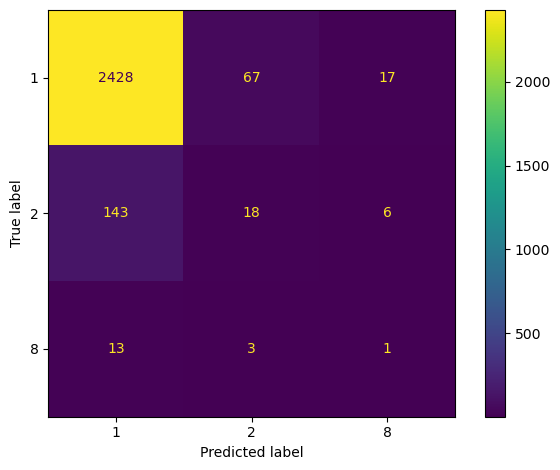

In [112]:
disp.plot()
plt.tight_layout()

## block10_sepconv3_act

In [113]:
histories, report, disp = extract_train_predict_cv('block10_sepconv3_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6649 - loss: 1.5371 - val_accuracy: 0.4305 - val_loss: 1.0977
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5132 - loss: 1.0683 - val_accuracy: 0.5395 - val_loss: 1.0245
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5745 - loss: 0.9027 - val_accuracy: 0.5651 - val_loss: 0.9836
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6293 - loss: 0.8020 - val_accuracy: 0.6396 - val_loss: 0.9090
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7079 - loss: 0.8077 - val_accuracy: 0.6897 - val_loss: 0.8576
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6854 - loss: 0.7545 - val_accuracy: 0.7208 - val_loss: 0.8106
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7844 - loss: 0.6302 - val_a

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

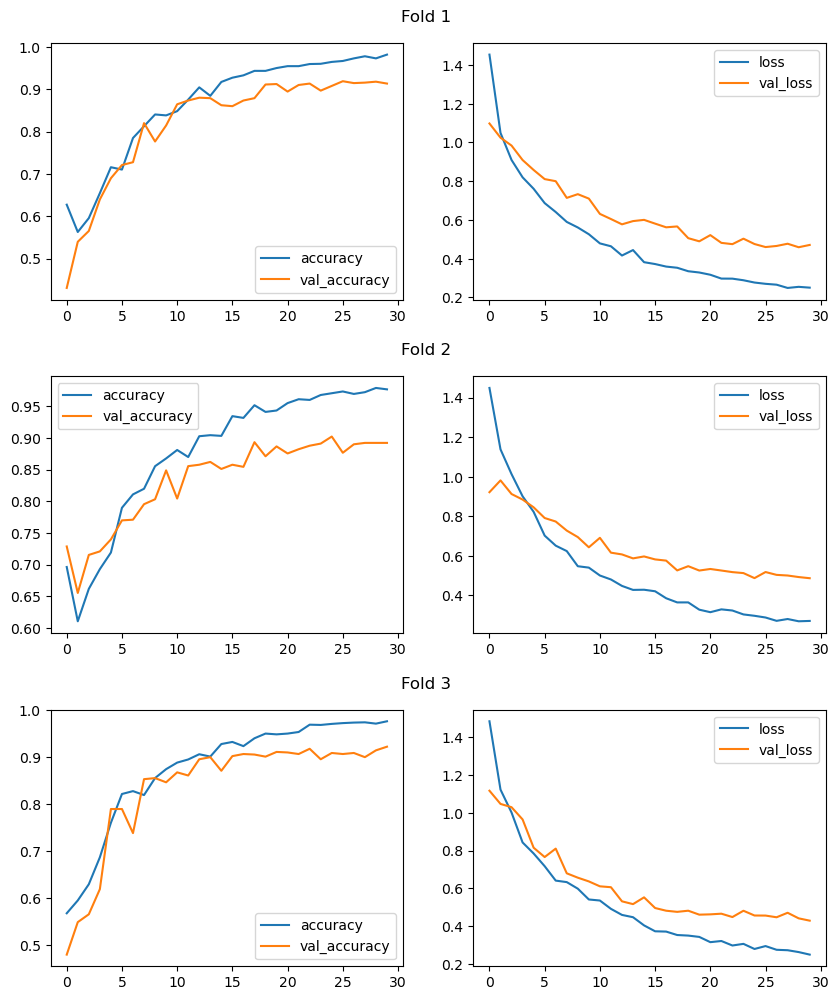

In [114]:
plot_history(histories)

In [115]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.97      0.95      2512
           2       0.17      0.09      0.12       167
           8       0.00      0.00      0.00        17

    accuracy                           0.91      2696
   macro avg       0.37      0.35      0.36      2696
weighted avg       0.88      0.91      0.90      2696



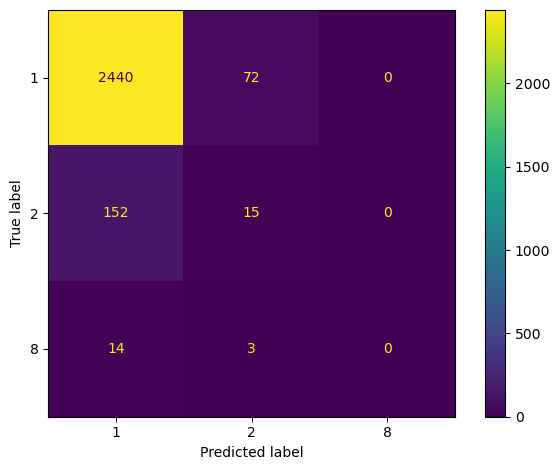

In [116]:
disp.plot()
plt.tight_layout()

## block11_sepconv1_act

In [45]:
history, report, disp = extract_train_predict_cv('block11_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5287 - loss: 2.5336 - val_accuracy: 0.3626 - val_loss: 1.5195
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4883 - loss: 1.1512 - val_accuracy: 0.4004 - val_loss: 1.3671
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5561 - loss: 0.8567 - val_accuracy: 0.7353 - val_loss: 0.7828
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6658 - loss: 0.6685 - val_accuracy: 0.6796 - val_loss: 0.8314
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7282 - loss: 0.5717 - val_accuracy: 0.6908 - val_loss: 0.8453
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7332 - loss: 0.5757 - val_accuracy: 0.8020 - val_loss: 0.6916
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8140 - loss: 0.4723 - val_a

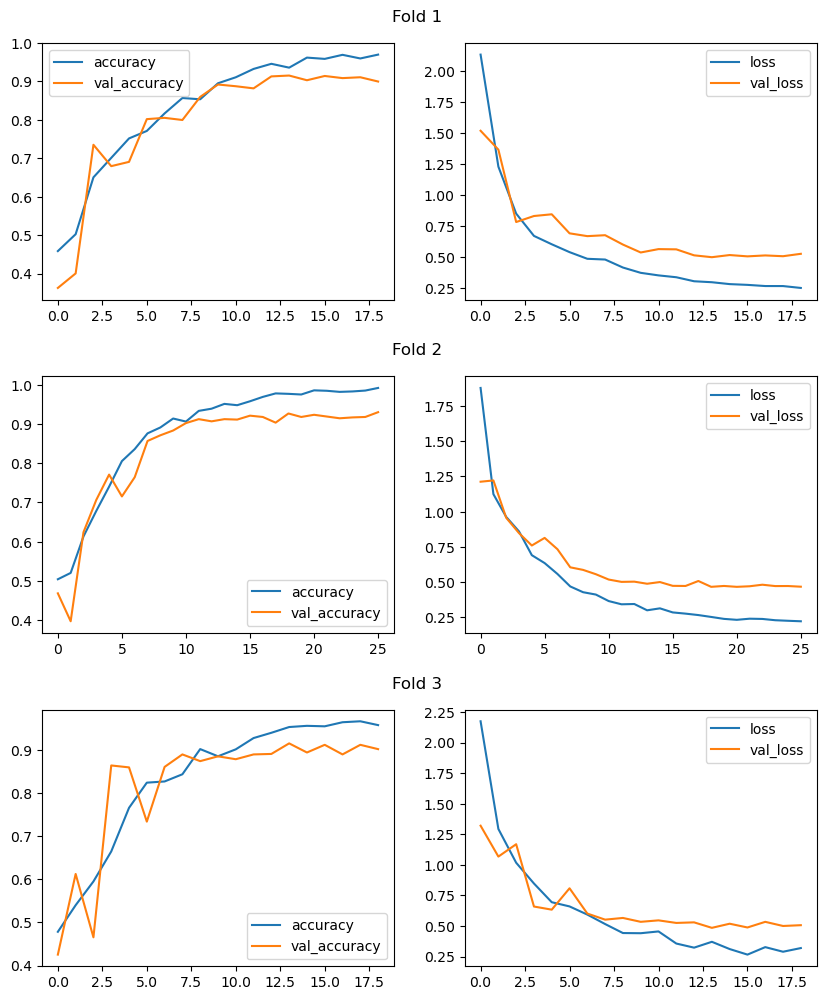

In [46]:
plot_history(history)

In [47]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.98      0.96      2512
           2       0.21      0.08      0.12       167
           8       0.00      0.00      0.00        17

    accuracy                           0.92      2696
   macro avg       0.38      0.35      0.36      2696
weighted avg       0.89      0.92      0.90      2696



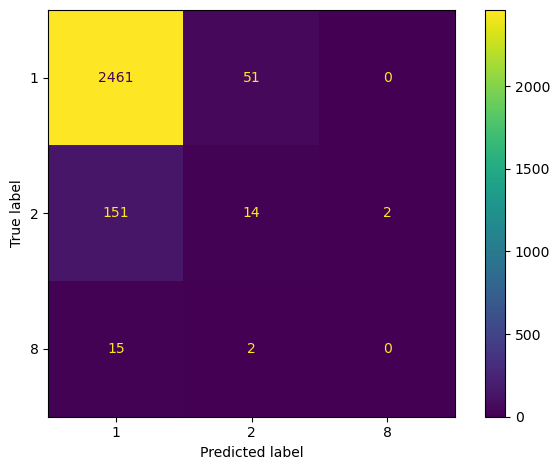

In [48]:
disp.plot()
plt.tight_layout()

## block6_sepconv1_act

In [49]:
history, report, disp = extract_train_predict_cv('block6_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5489 - loss: 2.0383 - val_accuracy: 0.5339 - val_loss: 1.1147
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5018 - loss: 1.1054 - val_accuracy: 0.5328 - val_loss: 1.1131
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4449 - loss: 0.9650 - val_accuracy: 0.6363 - val_loss: 0.9380
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6043 - loss: 0.7851 - val_accuracy: 0.5984 - val_loss: 0.9222
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6342 - loss: 0.7625 - val_accuracy: 0.8165 - val_loss: 0.7579
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6984 - loss: 0.6970 - val_accuracy: 0.8420 - val_loss: 0.6797
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7741 - loss: 0.5753 - val_a

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

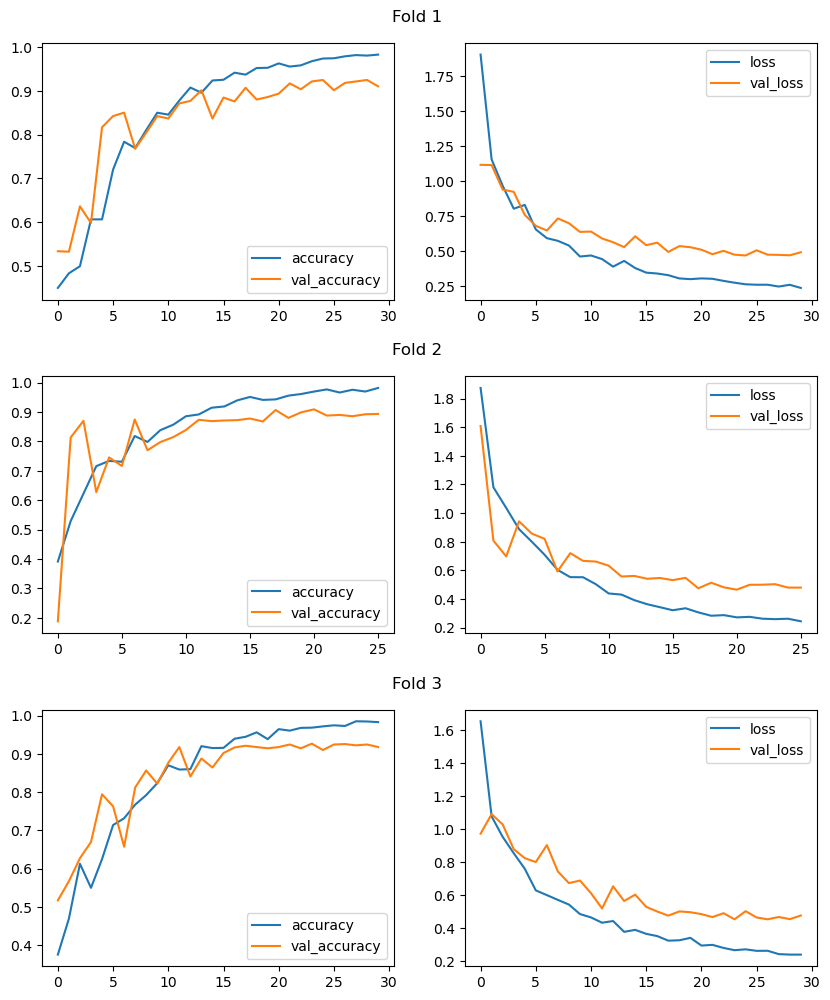

In [50]:
plot_history(history)

In [51]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.98      0.96      2512
           2       0.18      0.05      0.08       167
           8       0.00      0.00      0.00        17

    accuracy                           0.92      2696
   macro avg       0.37      0.35      0.35      2696
weighted avg       0.88      0.92      0.90      2696



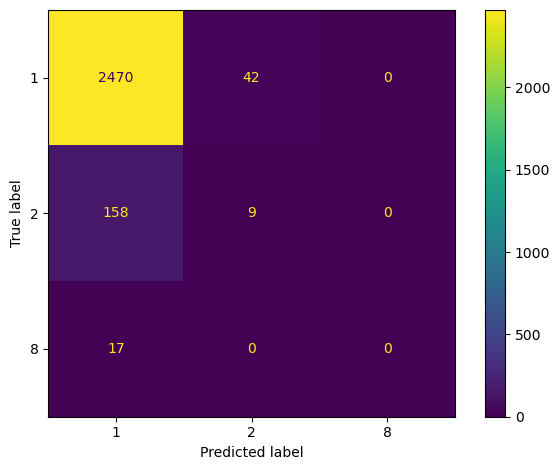

In [52]:
disp.plot()
plt.tight_layout()

## block6_sepconv2_act ("best" so far)

In [53]:
history, report, disp = extract_train_predict_cv('block6_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5067 - loss: 1.6837 - val_accuracy: 0.6429 - val_loss: 0.9891
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6715 - loss: 1.2704 - val_accuracy: 0.5962 - val_loss: 1.0035
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6952 - loss: 1.1252 - val_accuracy: 0.7141 - val_loss: 0.8735
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7034 - loss: 0.9218 - val_accuracy: 0.7597 - val_loss: 0.8366
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7404 - loss: 0.6896 - val_accuracy: 0.6730 - val_loss: 0.8392
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7310 - loss: 0.6296 - val_accuracy: 0.8420 - val_loss: 0.6994
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8187 - loss: 0.5869 - val_a

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

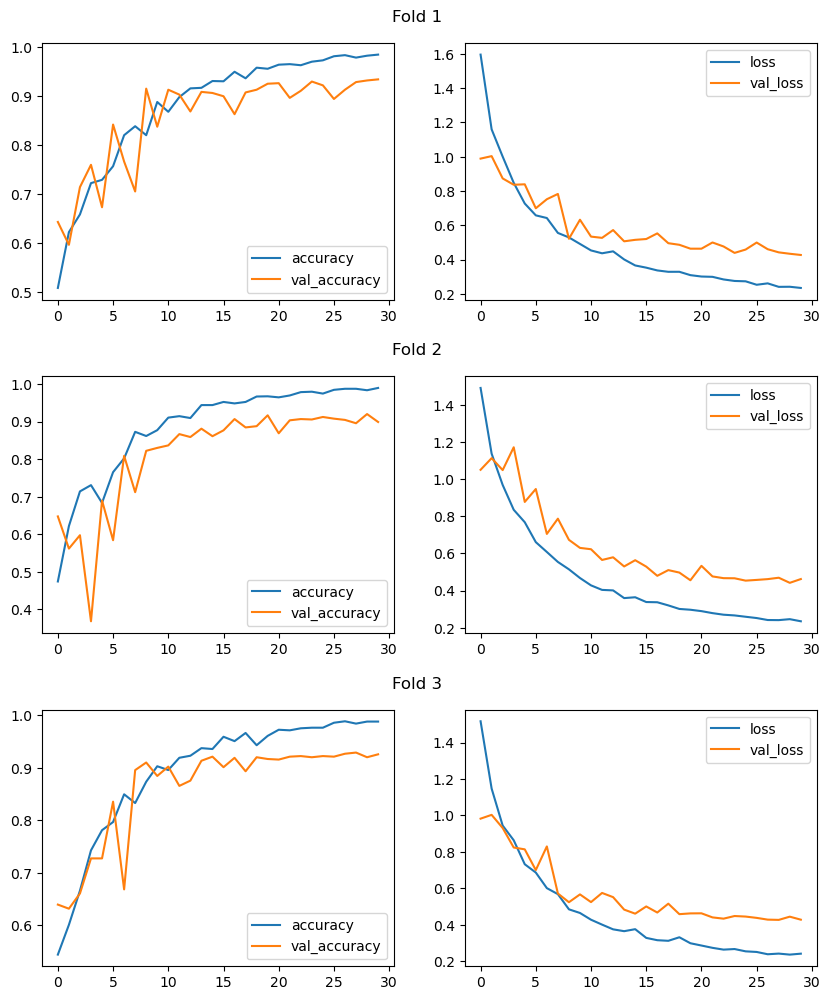

In [54]:
plot_history(history)

In [55]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.99      0.96      2512
           2       0.35      0.10      0.16       167
           8       0.00      0.00      0.00        17

    accuracy                           0.93      2696
   macro avg       0.43      0.36      0.37      2696
weighted avg       0.90      0.93      0.91      2696



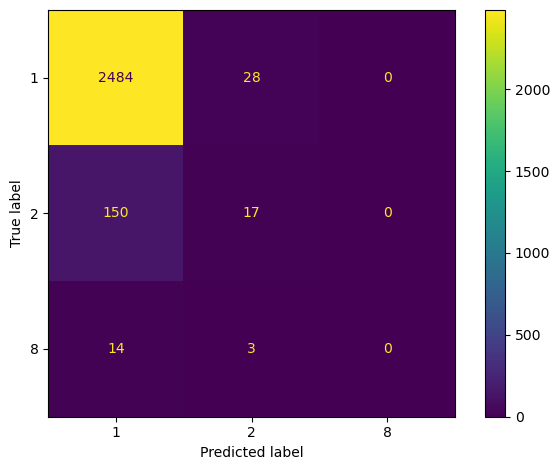

In [56]:
disp.plot()
plt.tight_layout()

## block6_sepconv3_act

In [57]:
histories, report, disp = extract_train_predict_cv('block6_sepconv3_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7691 - loss: 1.6550 - val_accuracy: 0.4449 - val_loss: 1.0699
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5114 - loss: 1.2061 - val_accuracy: 0.7386 - val_loss: 0.8968
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7464 - loss: 0.8334 - val_accuracy: 0.6730 - val_loss: 0.8836
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7479 - loss: 0.8062 - val_accuracy: 0.6363 - val_loss: 0.8961
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6670 - loss: 0.7428 - val_accuracy: 0.8331 - val_loss: 0.7212
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7906 - loss: 0.6574 - val_accuracy: 0.8532 - val_loss: 0.6740
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8622 - loss: 0.6635 - val_a

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

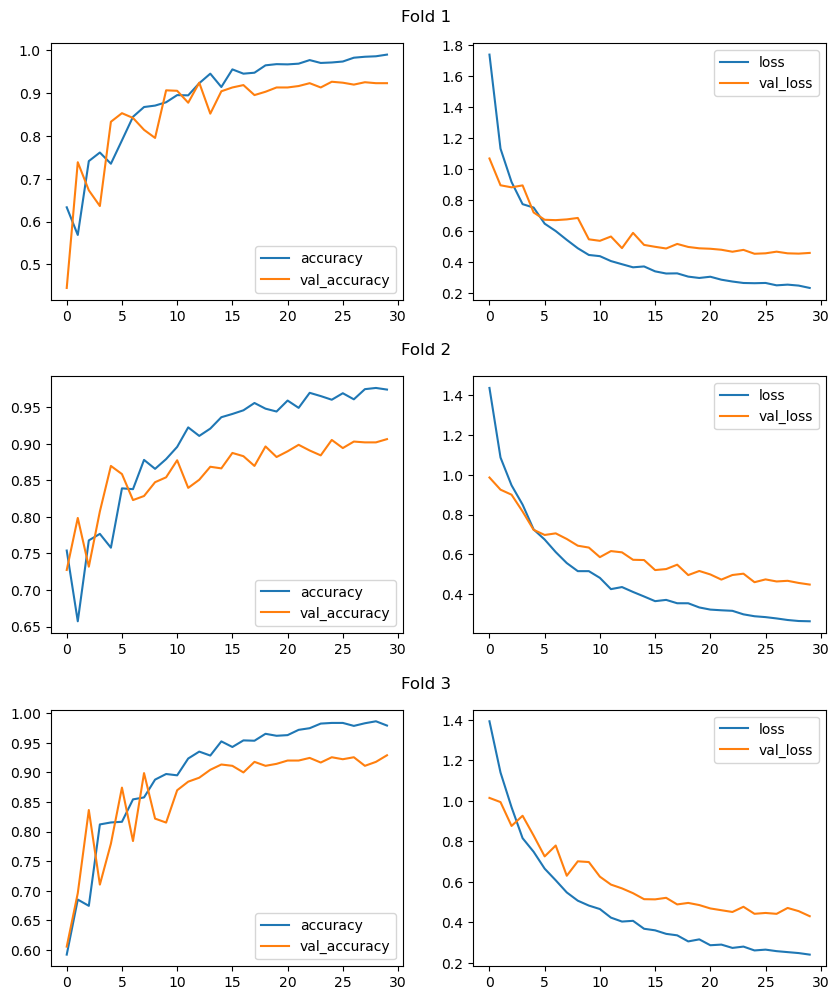

In [58]:
plot_history(histories)

In [59]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.98      0.96      2512
           2       0.25      0.10      0.14       167
           8       0.00      0.00      0.00        17

    accuracy                           0.92      2696
   macro avg       0.40      0.36      0.37      2696
weighted avg       0.89      0.92      0.90      2696



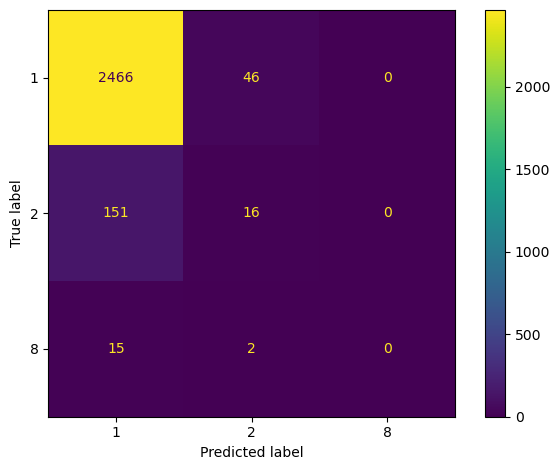

In [60]:
disp.plot()
plt.tight_layout()

## block1_conv1_act

In [61]:
histories, report, disp = extract_train_predict_cv('block1_conv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Shape of features: (2696, 63, 63, 32)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.4221 - loss: 3.3447 - val_accuracy: 0.8287 - val_loss: 0.9370
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2343 - loss: 1.6846 - val_accuracy: 0.0567 - val_loss: 1.4435
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2998 - loss: 1.3342 - val_accuracy: 0.0779 - val_loss: 1.3757
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2457 - loss: 1.3600 - val_accuracy: 0.0578 - val_loss: 1.4510
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3016 - loss: 1.4102 - val_accuracy: 0.0601 - val_loss: 1.3777
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2778 - loss: 1.2498 - val_accuracy: 0.0378 - val_loss: 1.4969
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2281 - loss: 1.1594 - val_

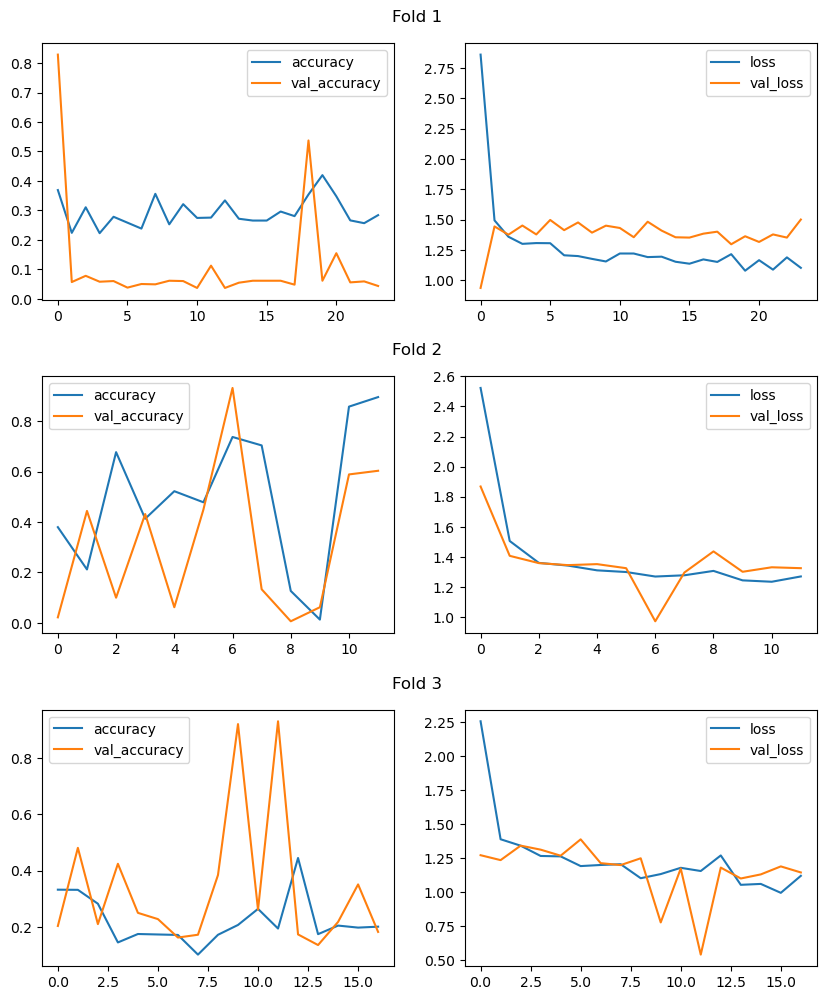

In [62]:
plot_history(histories)

In [63]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.85      0.89      2512
           2       0.06      0.15      0.09       167
           8       0.05      0.06      0.05        17

    accuracy                           0.80      2696
   macro avg       0.35      0.35      0.34      2696
weighted avg       0.87      0.80      0.83      2696



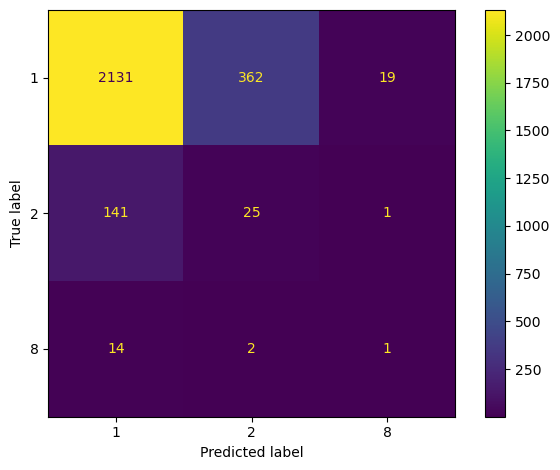

In [64]:
disp.plot()
plt.tight_layout()

## block1_conv2_act

In [65]:
histories, report, disp = extract_train_predict_cv('block1_conv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Shape of features: (2696, 61, 61, 64)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.4862 - loss: 3.3637 - val_accuracy: 0.0556 - val_loss: 2.0473
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4387 - loss: 1.3620 - val_accuracy: 0.0378 - val_loss: 1.6198
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3147 - loss: 1.4234 - val_accuracy: 0.8465 - val_loss: 1.2273
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4485 - loss: 1.3943 - val_accuracy: 0.0901 - val_loss: 1.2826
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1096 - loss: 1.2359 - val_accuracy: 0.8521 - val_loss: 1.0081
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5665 - loss: 1.1027 - val_accuracy: 0.2970 - val_loss: 1.4386
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5030 - loss: 1.1580 -

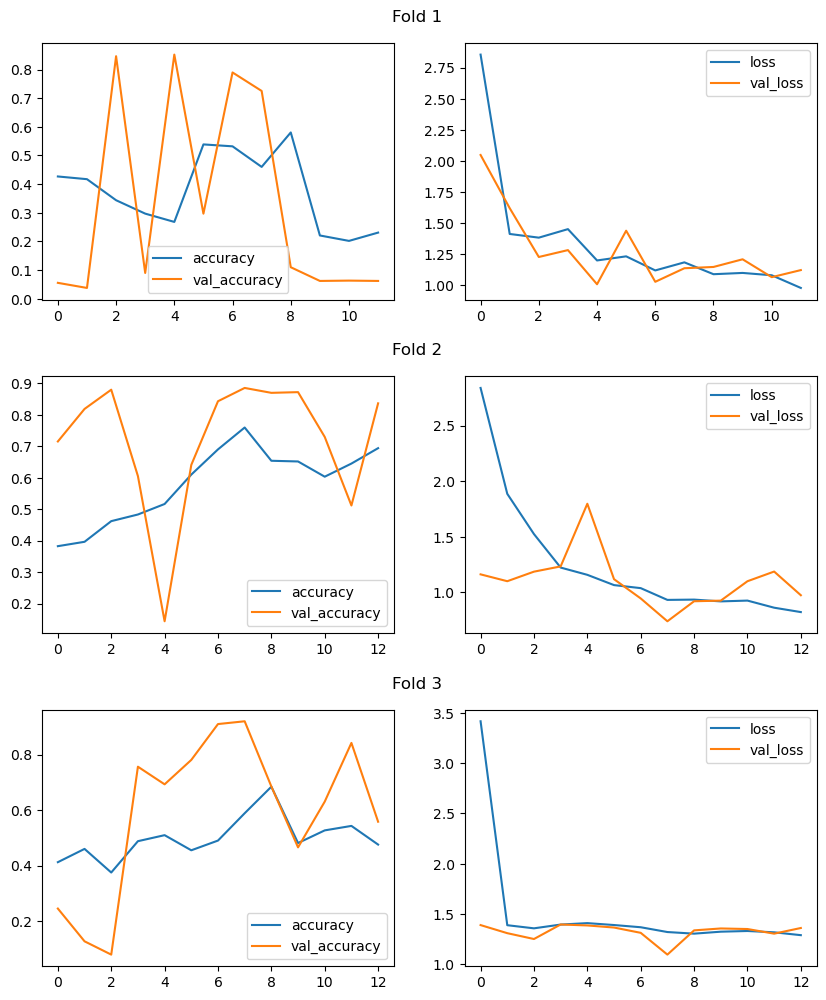

In [66]:
plot_history(histories)

In [67]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.92      0.93      2512
           2       0.08      0.08      0.08       167
           8       0.02      0.06      0.03        17

    accuracy                           0.86      2696
   macro avg       0.34      0.35      0.35      2696
weighted avg       0.87      0.86      0.87      2696



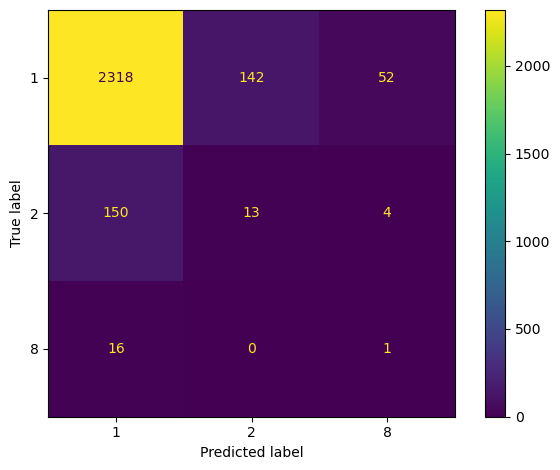

In [68]:
disp.plot()
plt.tight_layout()

## block2_sepconv2_act

In [73]:
histories, report, disp = extract_train_predict_cv('block2_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Shape of features: (2696, 61, 61, 128)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.4717 - loss: 5.1166 - val_accuracy: 0.8676 - val_loss: 1.0629
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5560 - loss: 1.4029 - val_accuracy: 0.0823 - val_loss: 1.6893
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2749 - loss: 1.1128 - val_accuracy: 0.5717 - val_loss: 1.2567
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3140 - loss: 1.0570 - val_accuracy: 0.4650 - val_loss: 1.2908
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5152 - loss: 0.9924 - val_accuracy: 0.8687 - val_loss: 1.0662
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5757 - loss: 1.0382 - val_accuracy: 0.4594 - val_loss: 1.2728
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5614 - loss: 1.045

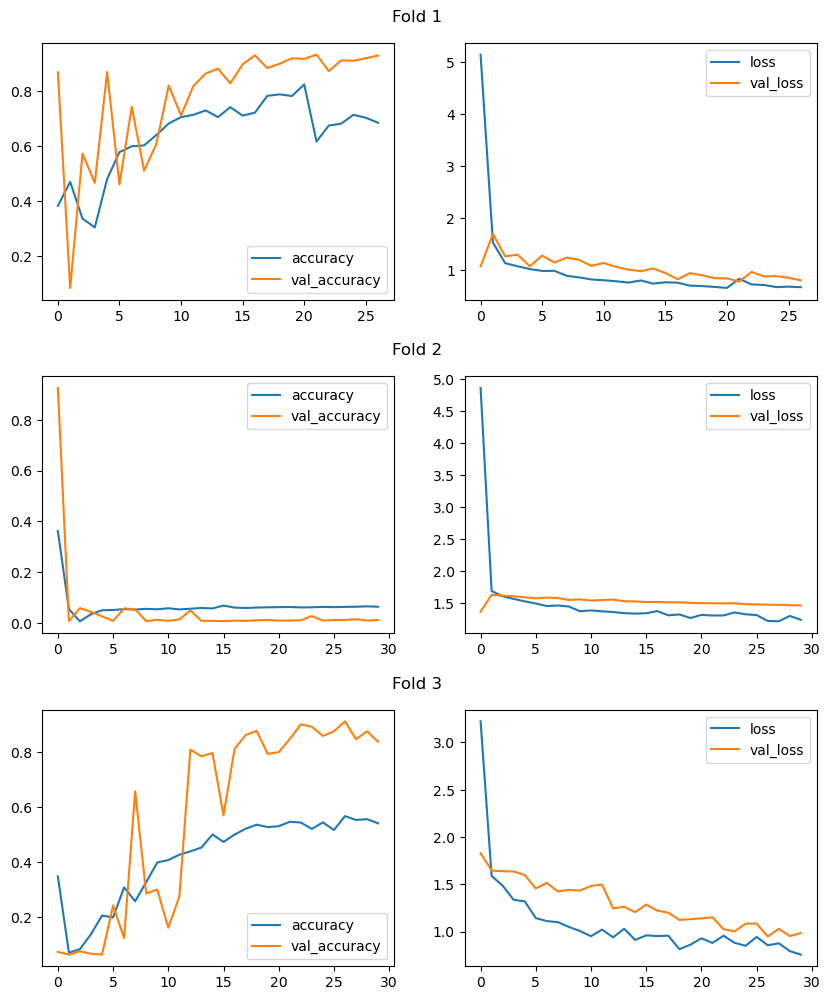

In [74]:
plot_history(histories)

In [75]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.66      0.77      2512
           2       0.13      0.03      0.05       167
           8       0.01      0.35      0.01        17

    accuracy                           0.62      2696
   macro avg       0.36      0.35      0.28      2696
weighted avg       0.88      0.62      0.72      2696



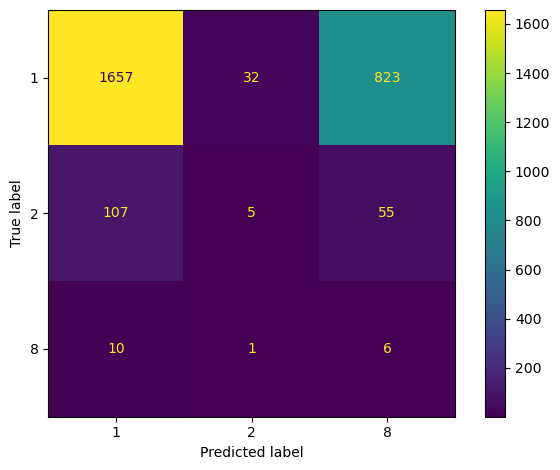

In [76]:
disp.plot()
plt.tight_layout()

Layer predicted high number of 8s

## block3_sepconv1_act

In [85]:
histories, report, disp = extract_train_predict_cv('block3_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Shape of features: (2696, 31, 31, 128)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.3990 - loss: 4.1486 - val_accuracy: 0.2981 - val_loss: 1.4900
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3015 - loss: 1.8991 - val_accuracy: 0.0667 - val_loss: 1.5571
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3177 - loss: 1.2761 - val_accuracy: 0.3637 - val_loss: 1.2502
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5340 - loss: 1.0658 - val_accuracy: 0.3838 - val_loss: 1.3450
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6042 - loss: 1.1756 - val_accuracy: 0.8776 - val_loss: 1.0608
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5990 - loss: 1.1554 - val_accuracy: 0.7531 - val_loss: 1.0848
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5351 - loss: 1.1179 - val_

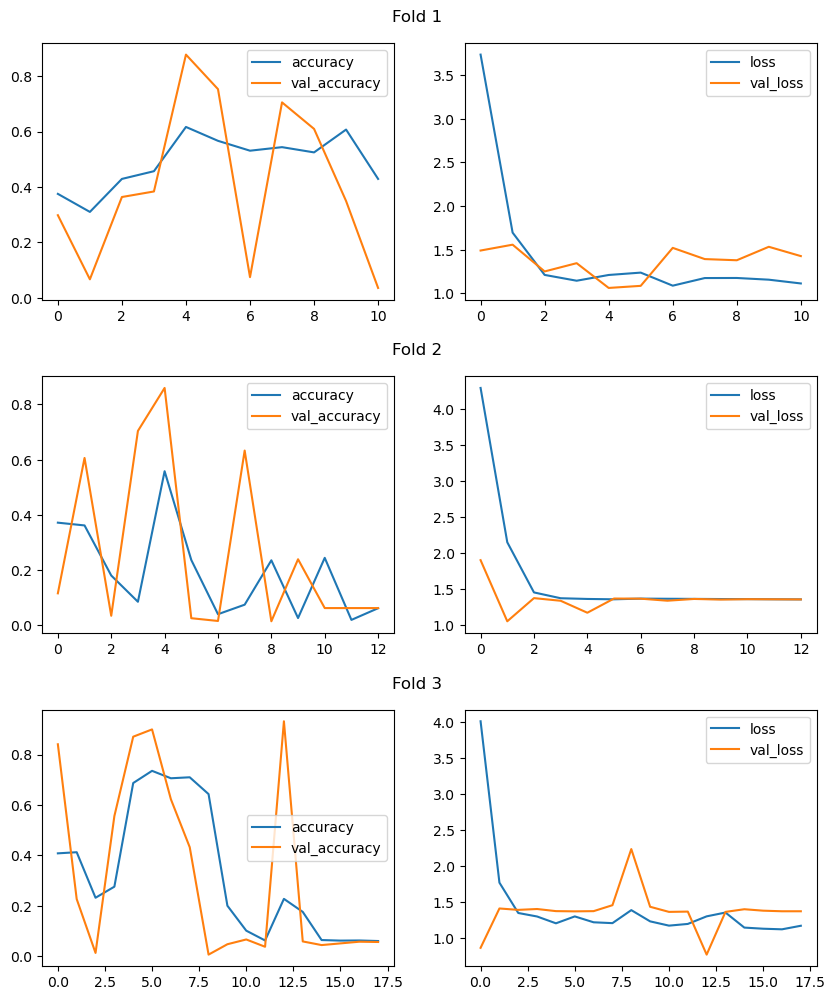

In [86]:
plot_history(histories)

In [87]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.82      0.87      2512
           2       0.05      0.06      0.06       167
           8       0.01      0.18      0.02        17

    accuracy                           0.77      2696
   macro avg       0.33      0.35      0.32      2696
weighted avg       0.87      0.77      0.82      2696



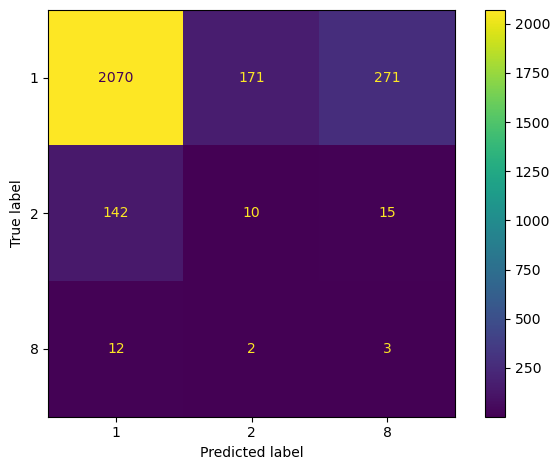

In [88]:
disp.plot()
plt.tight_layout()

## block3_sepconv2_act

In [77]:
histories, report, disp = extract_train_predict_cv('block3_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Shape of features: (2696, 31, 31, 256)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.5584 - loss: 2.4634 - val_accuracy: 0.1190 - val_loss: 1.5950
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2980 - loss: 1.5564 - val_accuracy: 0.3404 - val_loss: 1.4128
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1430 - loss: 1.2227 - val_accuracy: 0.3904 - val_loss: 1.3274
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1853 - loss: 1.3781 - val_accuracy: 0.4850 - val_loss: 1.2206
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4743 - loss: 1.4480 - val_accuracy: 0.5506 - val_loss: 1.0933
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4074 - loss: 1.1307 - val_accuracy: 0.0901 - val_loss: 1.2559
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1112 - loss: 1.1716 

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

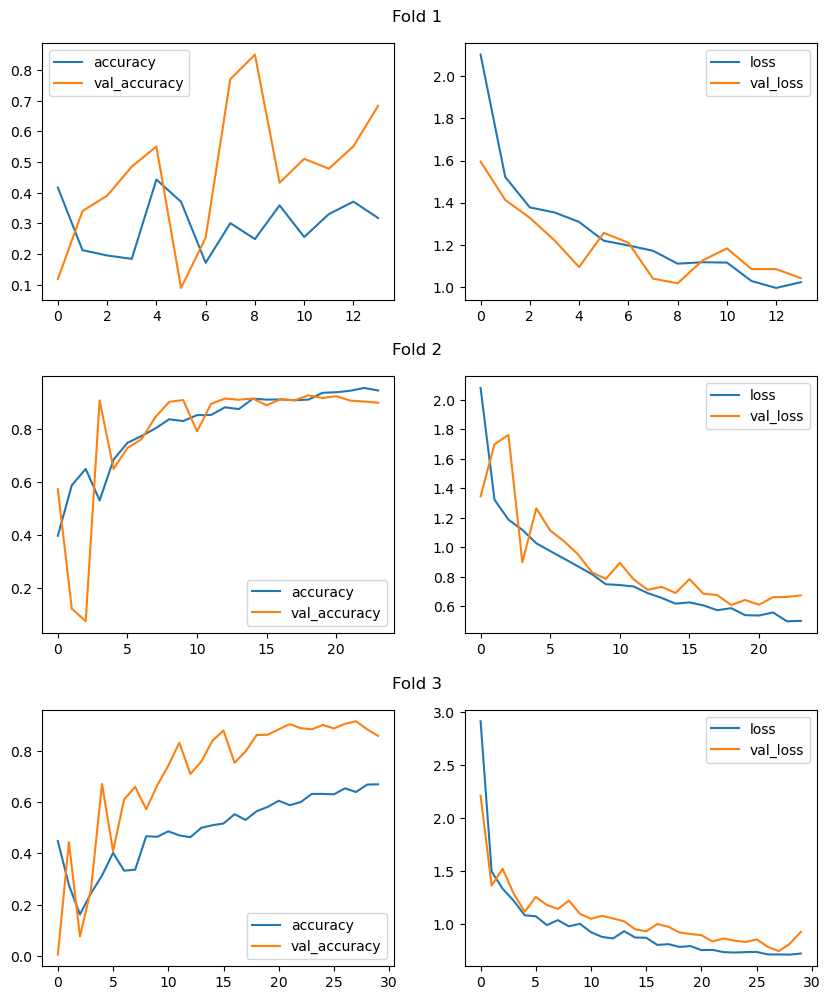

In [78]:
plot_history(histories)

In [79]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.96      0.95      2512
           2       0.06      0.04      0.04       167
           8       0.00      0.00      0.00        17

    accuracy                           0.90      2696
   macro avg       0.33      0.33      0.33      2696
weighted avg       0.87      0.90      0.88      2696



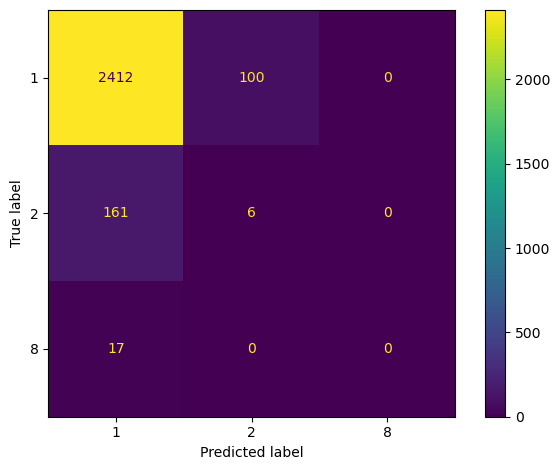

In [80]:
disp.plot()
plt.tight_layout()

## block13_sepconv1_act

In [89]:
histories, report, disp = extract_train_predict_cv('block13_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5103 - loss: 2.4407 - val_accuracy: 0.3137 - val_loss: 1.3689
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3861 - loss: 1.2502 - val_accuracy: 0.7030 - val_loss: 0.8858
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5485 - loss: 0.9133 - val_accuracy: 0.6385 - val_loss: 0.9017
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6935 - loss: 0.6325 - val_accuracy: 0.6374 - val_loss: 0.8870
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7282 - loss: 0.5846 - val_accuracy: 0.6218 - val_loss: 0.8781
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7281 - loss: 0.5593 - val_accuracy: 0.7875 - val_loss: 0.7222
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7979 - loss: 0.4723 - val_a

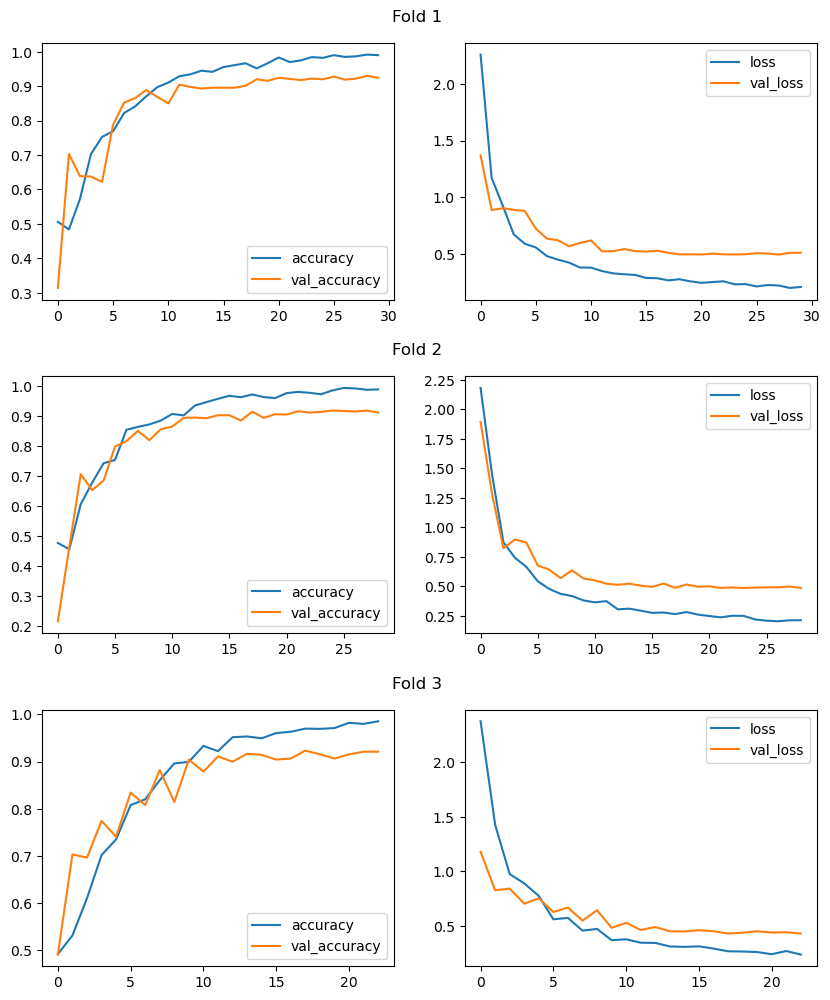

In [90]:
plot_history(histories)

In [91]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.98      0.96      2512
           2       0.16      0.04      0.07       167
           8       0.00      0.00      0.00        17

    accuracy                           0.92      2696
   macro avg       0.36      0.34      0.34      2696
weighted avg       0.88      0.92      0.90      2696



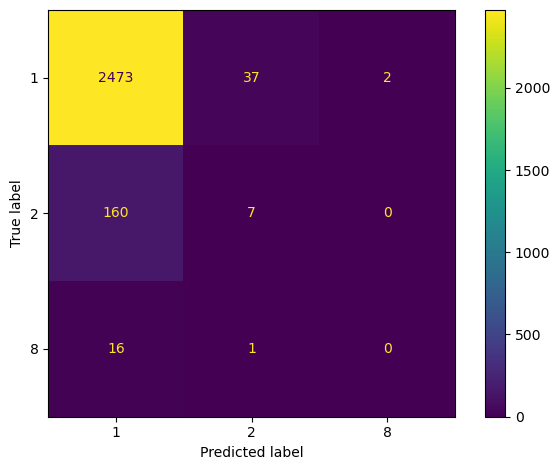

In [92]:
disp.plot()
plt.tight_layout()

## block13_sepconv2_act

In [93]:
histories, report, disp = extract_train_predict_cv('block13_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4632 - loss: 1.3643 - val_accuracy: 0.5228 - val_loss: 1.0143
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5944 - loss: 1.1022 - val_accuracy: 0.6696 - val_loss: 0.9354
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6605 - loss: 1.0420 - val_accuracy: 0.6274 - val_loss: 0.9475
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6899 - loss: 0.9107 - val_accuracy: 0.7219 - val_loss: 0.8501
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7060 - loss: 0.6997 - val_accuracy: 0.7731 - val_loss: 0.7780
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8092 - loss: 0.7633 - val_accuracy: 0.7964 - val_loss: 0.7472
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8287 - loss: 0.5803 - val_a

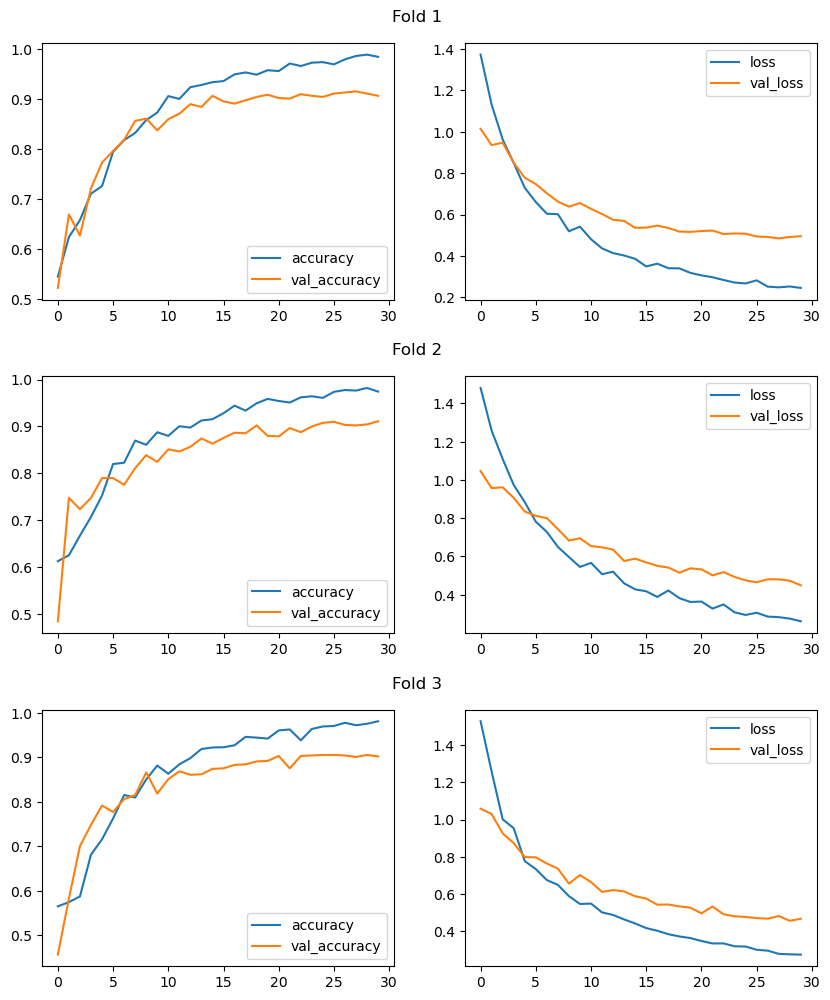

In [94]:
plot_history(histories)

In [95]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.97      0.95      2512
           2       0.14      0.07      0.10       167
           8       0.00      0.00      0.00        17

    accuracy                           0.91      2696
   macro avg       0.36      0.35      0.35      2696
weighted avg       0.88      0.91      0.89      2696



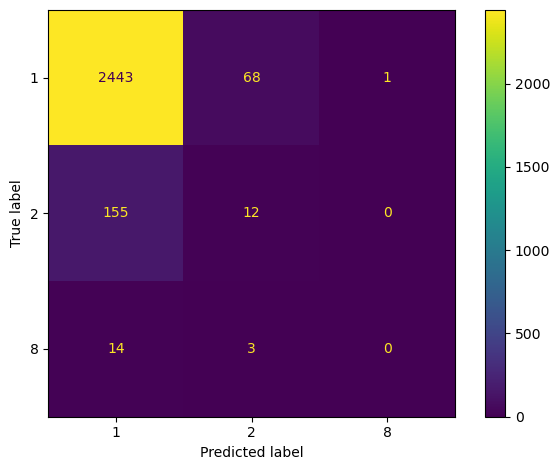

In [96]:
disp.plot()
plt.tight_layout()

## block14_sepconv1_act

In [97]:
histories, report, disp = extract_train_predict_cv('block14_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
Shape of features: (2696, 4, 4, 1536)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2716 - loss: 1.2676 - val_accuracy: 0.3949 - val_loss: 1.2090
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4568 - loss: 1.1747 - val_accuracy: 0.4583 - val_loss: 1.1502
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4998 - loss: 1.0374 - val_accuracy: 0.5106 - val_loss: 1.1238
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4767 - loss: 1.1433 - val_accuracy: 0.6263 - val_loss: 1.0592
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5539 - loss: 1.1272 - val_accuracy: 0.5595 - val_loss: 1.0642
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5304 - loss: 1.1300 - val_accuracy: 0.6018 - val_loss: 1.0281
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6119 - loss: 0.9395 - val_

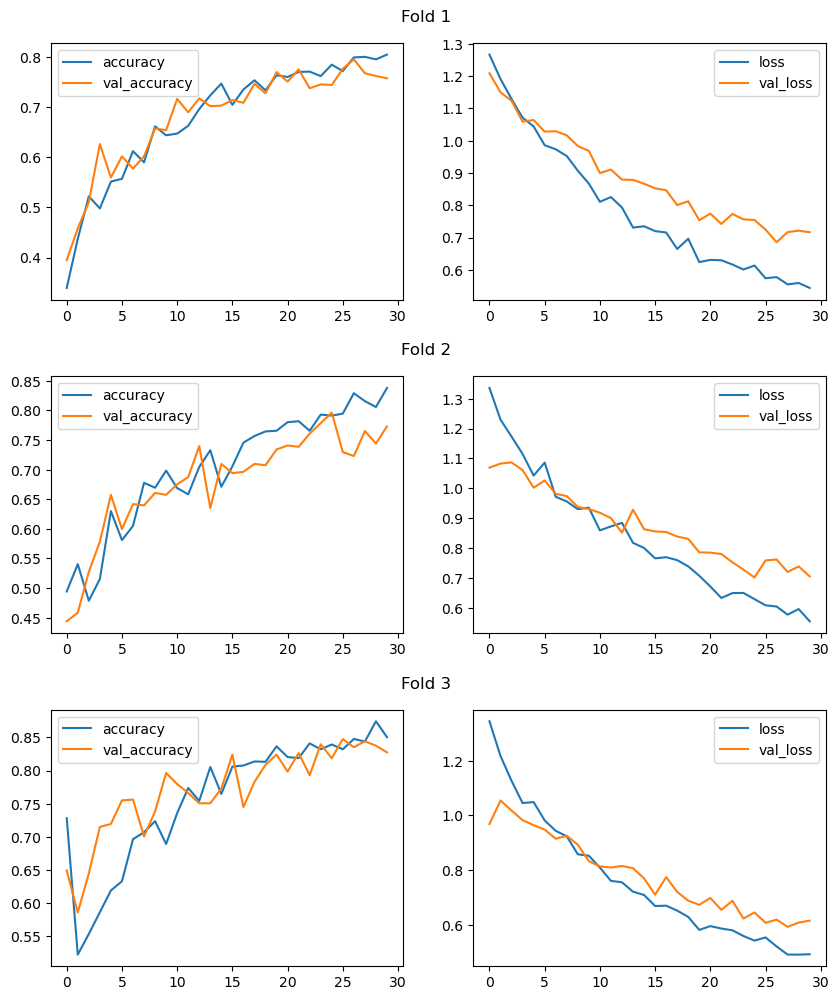

In [98]:
plot_history(histories)

In [99]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.86      0.90      2512
           2       0.11      0.25      0.15       167
           8       0.00      0.00      0.00        17

    accuracy                           0.81      2696
   macro avg       0.35      0.37      0.35      2696
weighted avg       0.89      0.81      0.85      2696



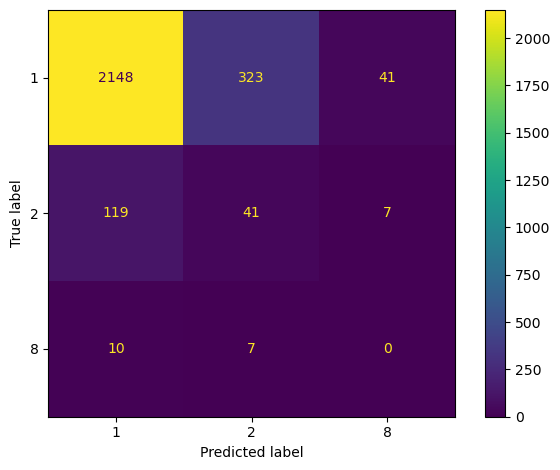

In [100]:
disp.plot()
plt.tight_layout()

## block14_sepconv2_act

In [101]:
histories, report, disp = extract_train_predict_cv('block14_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
Shape of features: (2696, 4, 4, 2048)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.3726 - loss: 1.8116 - val_accuracy: 0.3370 - val_loss: 1.3044
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4275 - loss: 1.1487 - val_accuracy: 0.6363 - val_loss: 0.9825
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5069 - loss: 1.0040 - val_accuracy: 0.5484 - val_loss: 1.0341
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5628 - loss: 0.8559 - val_accuracy: 0.5428 - val_loss: 0.9982
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5829 - loss: 0.7891 - val_accuracy: 0.5551 - val_loss: 1.0702
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5639 - loss: 0.9158 - val_accuracy: 0.6396 - val_loss: 0.8861
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6436 - loss: 0.7996 - val_

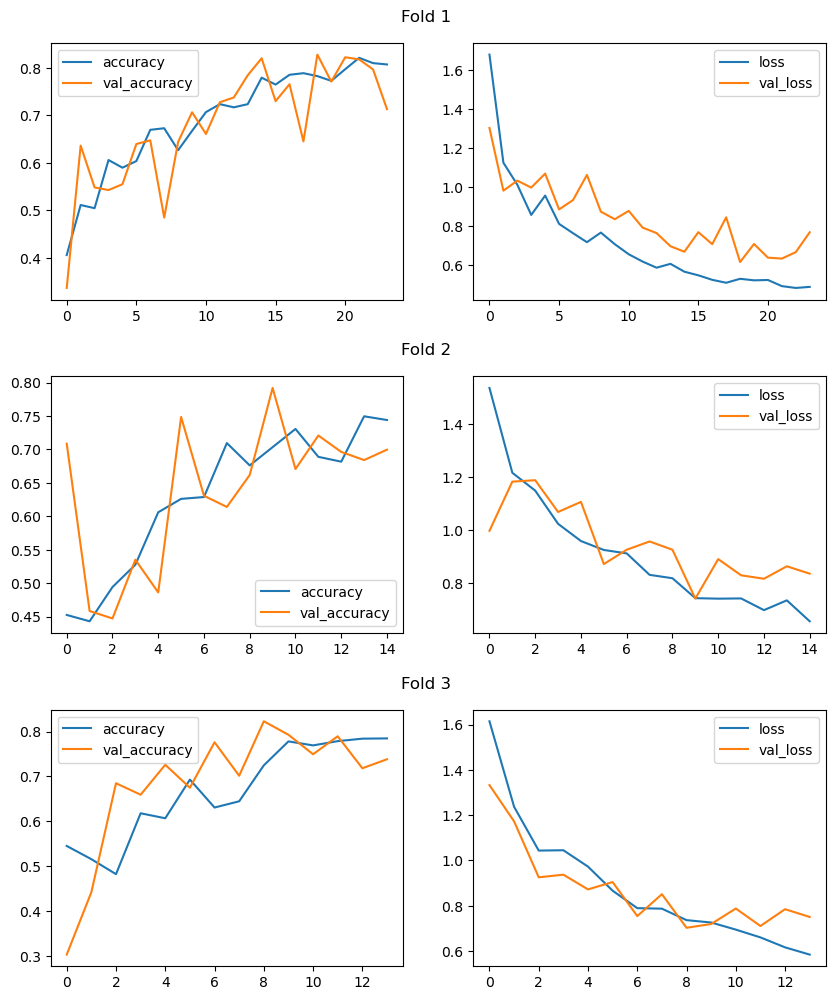

In [102]:
plot_history(histories)

In [103]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.86      0.90      2512
           2       0.11      0.22      0.15       167
           8       0.00      0.00      0.00        17

    accuracy                           0.81      2696
   macro avg       0.35      0.36      0.35      2696
weighted avg       0.88      0.81      0.85      2696



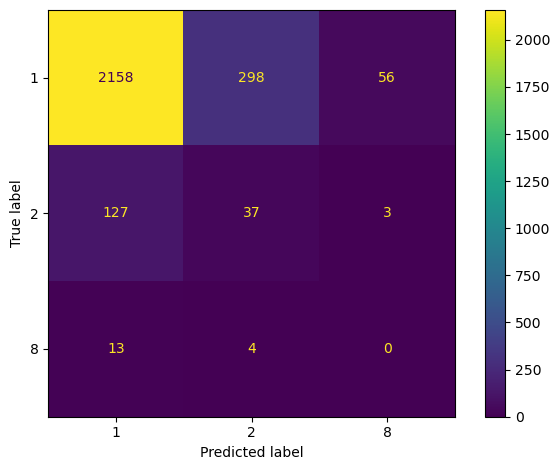

In [104]:
disp.plot()
plt.tight_layout()

Middle-end layers not predicting any 8s; angle may be low-mid level feature; need much more low-angle (8s) data to verify

## conv2d

Just a small test

In [153]:
histories, report, disp = extract_train_predict_cv('conv2d', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Shape of features: (2696, 31, 31, 128)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.4445 - loss: 9.3763 - val_accuracy: 0.0823 - val_loss: 2.5254
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3707 - loss: 1.7837 - val_accuracy: 0.1146 - val_loss: 1.3633
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4371 - loss: 1.2902 - val_accuracy: 0.0078 - val_loss: 1.3702
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0283 - loss: 1.7063 - val_accuracy: 0.0167 - val_loss: 1.3655
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0209 - loss: 1.4018 - val_accuracy: 0.1090 - val_loss: 1.3818
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1810 - loss: 1.6489 - val_accuracy: 0.0067 - val_loss: 1.3601
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0044 - loss: 1.2591 - val

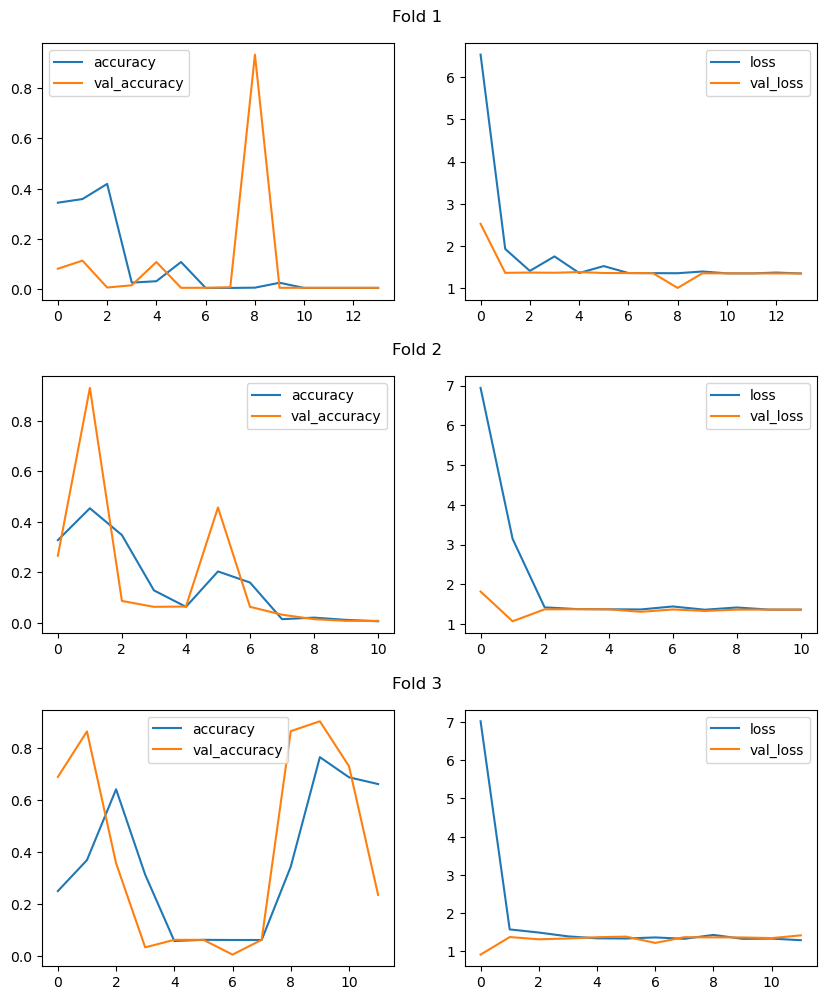

In [154]:
plot_history(histories)

In [155]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.49      0.64      2512
           2       0.05      0.15      0.08       167
           8       0.01      0.29      0.01        17

    accuracy                           0.47      2696
   macro avg       0.33      0.31      0.24      2696
weighted avg       0.87      0.47      0.60      2696



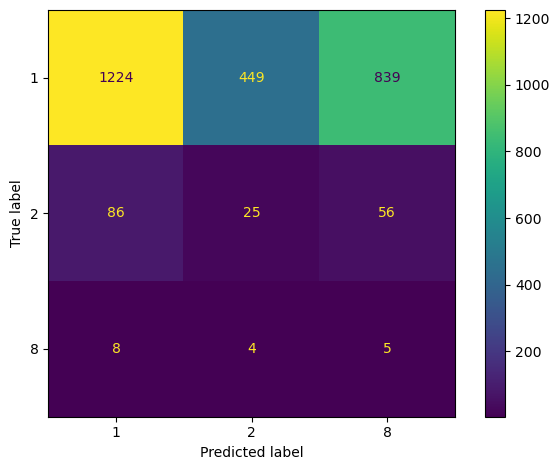

In [156]:
disp.plot()
plt.tight_layout()

## conv2d_1

In [157]:
histories, report, disp = extract_train_predict_cv('conv2d_1', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Shape of features: (2696, 16, 16, 256)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.3558 - loss: 9.6337 - val_accuracy: 0.1902 - val_loss: 1.5271
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3223 - loss: 3.0979 - val_accuracy: 0.0590 - val_loss: 1.3054
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0548 - loss: 1.4034 - val_accuracy: 0.0612 - val_loss: 1.2991
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0615 - loss: 1.2307 - val_accuracy: 0.0612 - val_loss: 1.2948
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0615 - loss: 1.2944 - val_accuracy: 0.0634 - val_loss: 1.2907
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0585 - loss: 1.1260 - val_accuracy: 0.0645 - val_loss: 1.2870
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0633 - loss: 1.3045 - val_

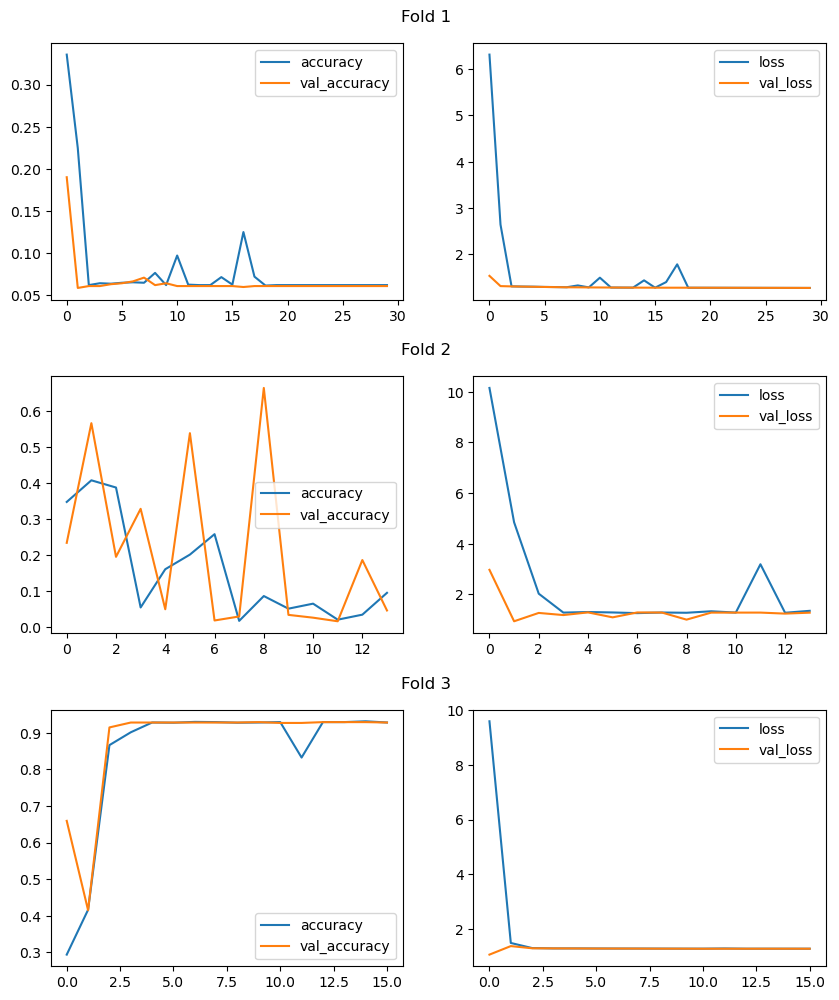

In [158]:
plot_history(histories)

In [159]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.57      0.70      2512
           2       0.06      0.34      0.10       167
           8       0.02      0.24      0.03        17

    accuracy                           0.55      2696
   macro avg       0.34      0.38      0.28      2696
weighted avg       0.87      0.55      0.66      2696



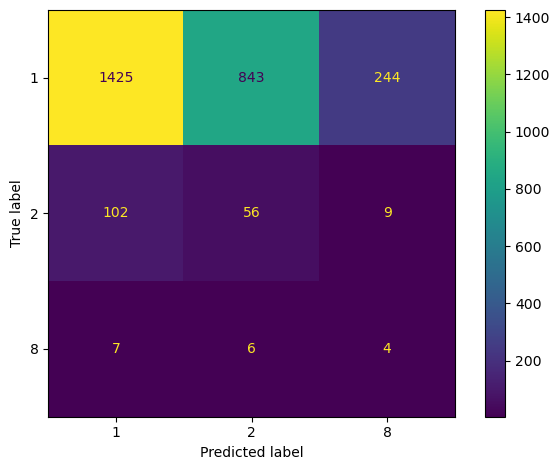

In [160]:
disp.plot()
plt.tight_layout()

## conv2d_2

In [161]:
histories, report, disp = extract_train_predict_cv('conv2d_2', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4615 - loss: 9.5572 - val_accuracy: 0.9077 - val_loss: 0.8482
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4848 - loss: 2.6658 - val_accuracy: 0.3749 - val_loss: 1.2390
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3210 - loss: 1.3599 - val_accuracy: 0.1513 - val_loss: 1.3062
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1256 - loss: 1.1508 - val_accuracy: 0.2692 - val_loss: 1.2363
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2932 - loss: 1.1147 - val_accuracy: 0.0612 - val_loss: 1.3053
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0789 - loss: 1.3032 - val_accuracy: 0.1101 - val_loss: 1.2982
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0865 - loss: 1.2525 - val_ac

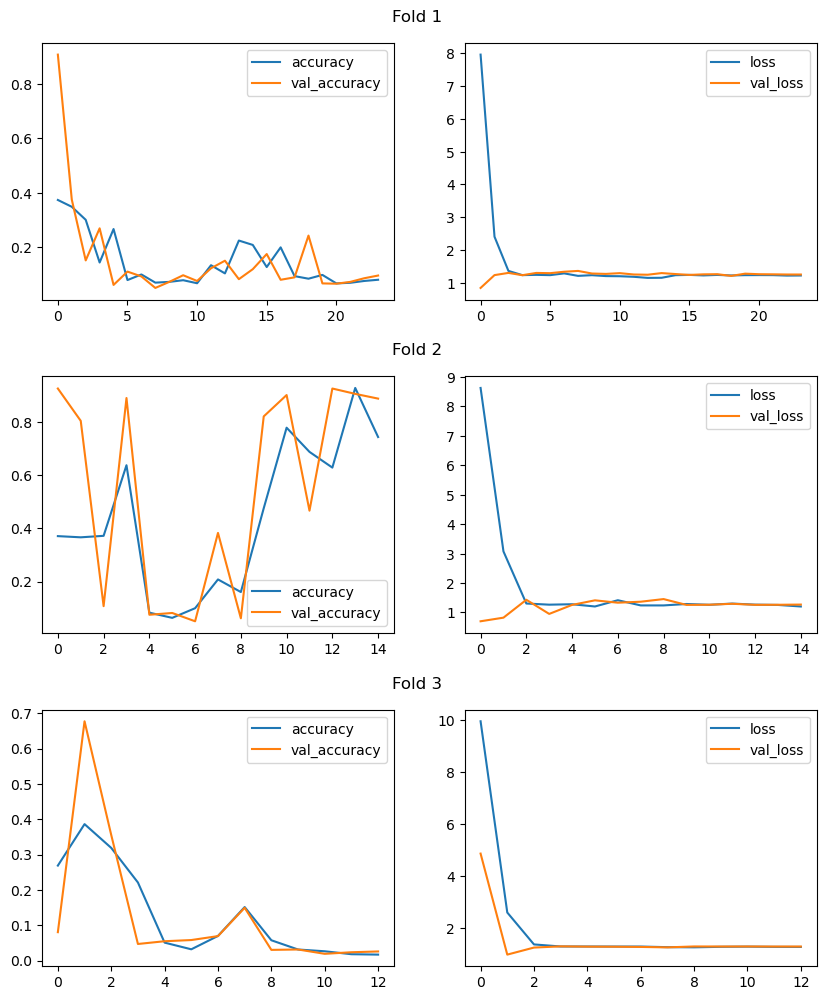

In [162]:
plot_history(histories)

In [163]:
print(report)

              precision    recall  f1-score   support

           1       0.93      0.41      0.57      2512
           2       0.06      0.31      0.10       167
           8       0.01      0.35      0.02        17

    accuracy                           0.40      2696
   macro avg       0.33      0.36      0.23      2696
weighted avg       0.87      0.40      0.54      2696



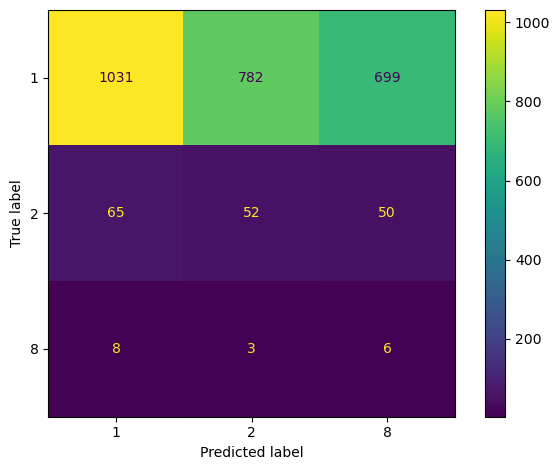

In [164]:
disp.plot()
plt.tight_layout()

## conv2d_3

In [165]:
histories, report, disp = extract_train_predict_cv('conv2d_3', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
Shape of features: (2696, 4, 4, 1024)
Training on fold 1...
Class weights: [ 0.35782557  5.34821429 54.45454545]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5265 - loss: 9.5619 - val_accuracy: 0.4194 - val_loss: 2.1774
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4483 - loss: 3.3645 - val_accuracy: 0.5862 - val_loss: 1.3976
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4887 - loss: 3.0462 - val_accuracy: 0.4638 - val_loss: 1.6087
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4093 - loss: 1.7100 - val_accuracy: 0.5606 - val_loss: 1.2304
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5207 - loss: 1.5166 - val_accuracy: 0.4872 - val_loss: 1.3433
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5115 - loss: 1.0576 - val_accuracy: 0.7197 - val_loss: 0.7990
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6121 - loss: 0.8878 - val_

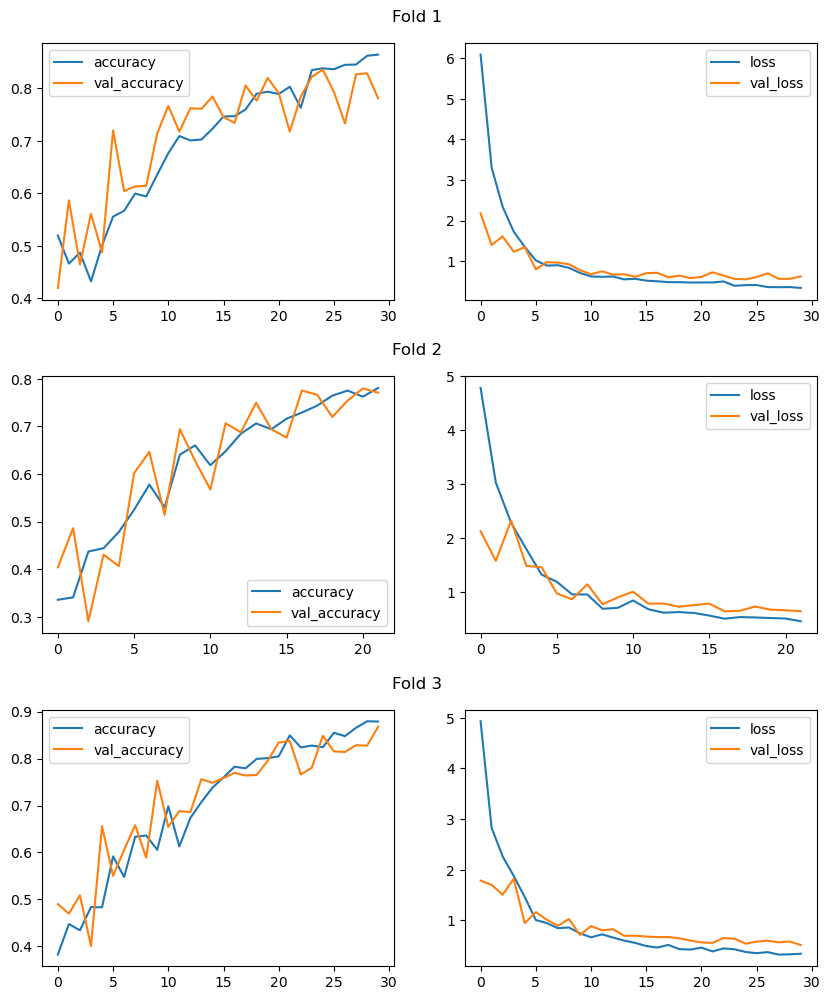

In [166]:
plot_history(histories)

In [167]:
print(report)

              precision    recall  f1-score   support

           1       0.94      0.87      0.90      2512
           2       0.11      0.23      0.15       167
           8       0.00      0.00      0.00        17

    accuracy                           0.83      2696
   macro avg       0.35      0.37      0.35      2696
weighted avg       0.88      0.83      0.85      2696



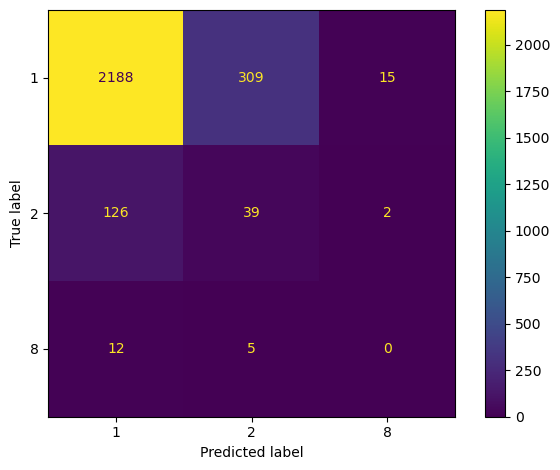

In [168]:
disp.plot()
plt.tight_layout()

Yeah I'm not sure what I was expecting